In [1]:
#Librerías para manejo de datos
import pandas as pd
import numpy as np

#Librerías para gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para modelar
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, StratifiedGroupKFold, StratifiedKFold, KFold,RandomizedSearchCV, RepeatedKFold, GridSearchCV, ParameterGrid
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, recall_score, accuracy_score,f1_score, make_scorer, classification_report
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

#Librería para tendencia al cluster
from pyclustertend import hopkins
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

#Librerías para visualización de barrios
import geopandas as gp
from seaborn import color_palette
import matplotlib.colors as colors

#grafico del arbol
from six import StringIO
from IPython.display import Image  
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree #,export_graphviz
import sklearn as sk

#preprocesamiento
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification
import multiprocessing

from sklearn.svm import SVC

In [2]:
import matplotlib                                #  ESTO ARREGLA EL ERROR
from matplotlib import rcParams, rcParamsDefault #  findfont: Generic family 'sans-serif' not found because none of the following families were found: 
rcParams.update(rcParamsDefault)                 #  BORRAR UNA VEZ SEGUROS QUE YA NO PASE

# Ejercicio 3

## Construccion del target

Para esta tarea se debe crear una nueva variable tipo_precio que tendrá tres categorías: alto, medio, bajo. Esta nueva variable será nuestra clase en el problema de clasificación.
Para determinar cuándo el tipo_precio de una propiedad es alto, medio o bajo se deberá analizar el precio por metro cuadrado (pxm2). Se propone evaluar las siguientes alternativas para establecer los límites de cada categoría.

In [3]:
df_tprecio = pd.read_csv('./data/properati_argentina_2021_filtrado.csv')
df_tprecio['pxm2'] = round(df_tprecio["property_price"] / df_tprecio['property_surface_total'], 0)
df_tprecio

latitud   longitud              place_l3 property_type  \
0     -34.589974 -58.459133               Palermo          Casa   
1     -34.637319 -58.361124                  Boca  Departamento   
2     -34.628647 -58.361871                  Boca  Departamento   
3     -34.610027 -58.401934                  Once  Departamento   
4     -34.631621 -58.416825                 Boedo            PH   
...          ...        ...                   ...           ...   
82658 -34.603245 -58.489810      Villa del Parque  Departamento   
82659 -34.614063 -58.482814      Villa del Parque  Departamento   
82660 -34.614175 -58.479062      Villa del Parque  Departamento   
82661 -34.614175 -58.479062      Villa del Parque  Departamento   
82662 -34.599790 -58.373411  Centro / Microcentro  Departamento   

       property_rooms  property_bedrooms  property_surface_total  \
0                   4                  3              171.000000   
1                   3                  2               58.000000   
2                   4                  3               70.000000   
3                   4                  2              135.327513   
4                   4                  2              106.415511   
...               ...                ...                     ...   
82658               4                  3              130.000000   
82659               3                  2               68.000000   
82660               1                  1               51.000000   
82661               1                  1               37.000000   
82662               2                  1               84.000000   

       property_surface_covered  property_price    pxm2  
0                         133.0        210000.0  1228.0  
1                          55.0         82900.0  1429.0  
2                          70.0         99000.0  1414.0  
3                         104.0        146000.0  1079.0  
4                          73.0        250000.0  2349.0  
...                         ...             ...     ...  
82658                     100.0        220000.0  1692.0  
82659                      60.0        161000.0  2368.0  
82660                      30.0         75500.0  1480.0  
82661                      31.0         74500.0  2014.0  
82662                      84.0        135000.0  1607.0  

[82663 rows x 10 columns]

Buscamos posibles outliers en el nuevo atributo creado

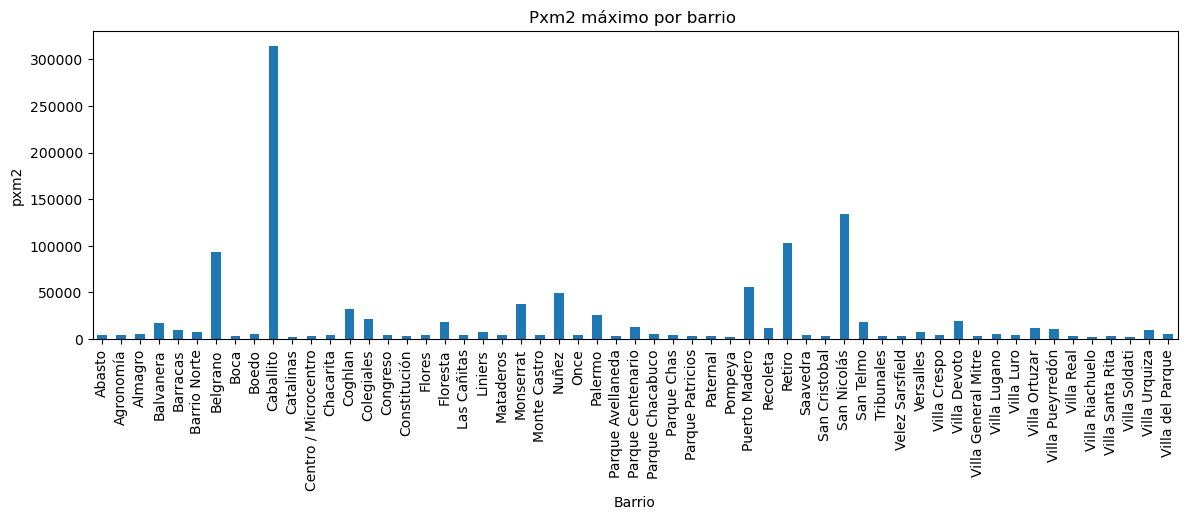

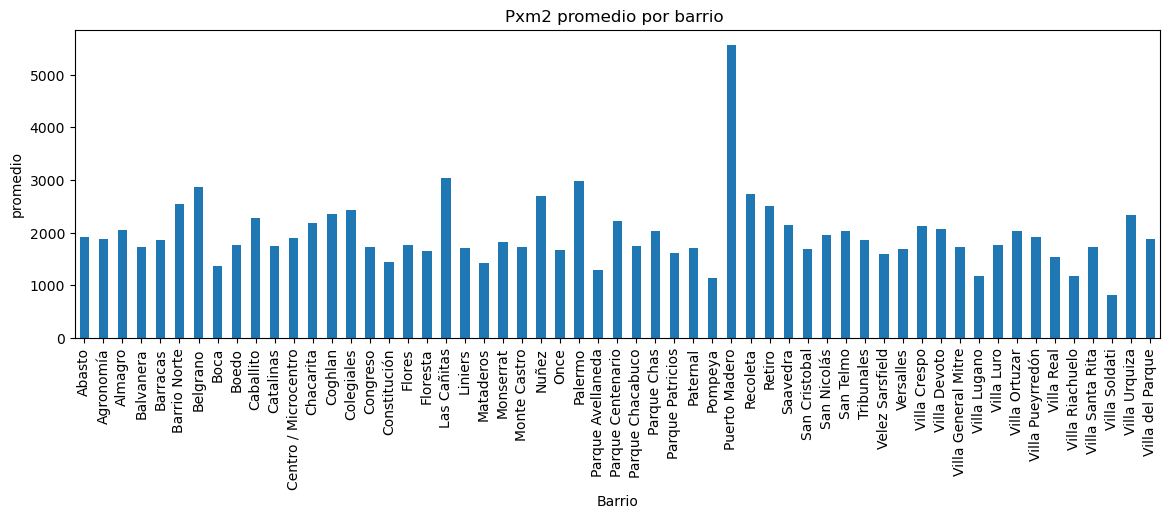

In [4]:
plt.rcParams['figure.figsize'] = (14,4)
df_tprecio.groupby(by=['place_l3'])['pxm2'].max().plot.bar(alpha=1 , title="Pxm2 máximo por barrio " , xlabel="Barrio" , ylabel="pxm2")
plt.show()

promedios_por_barrio = df_tprecio.groupby(by=['place_l3'])['pxm2'].mean()
promedios_por_barrio.plot.bar(alpha=1 , title="Pxm2 promedio por barrio " , xlabel="Barrio" , ylabel="promedio")
plt.show()

Si bien el promedio se ve bien, notamos la precencia de varios outliers. Procedemos a normalizar los valores de pxm2 para asi eliminar los outliers.

In [5]:
# Este max_pxm2_promedio va a ser el valor de arriba de Puerto Madero
max_pxm2_promedio = df_tprecio.groupby(by=['place_l3'])['pxm2'].mean().max();
promedios_por_barrio_dict = promedios_por_barrio.to_dict()
promedios_por_barrio_dict

{'Abasto': 1926.9064039408868,
 'Agronomía': 1873.762331838565,
 'Almagro': 2060.8274311410905,
 'Balvanera': 1730.6389010030528,
 'Barracas': 1869.8166368515206,
 'Barrio Norte': 2539.3086705202313,
 'Belgrano': 2873.575876504448,
 'Boca': 1367.442815249267,
 'Boedo': 1766.0113339145598,
 'Caballito': 2281.7981694073846,
 'Catalinas': 1743.2857142857142,
 'Centro / Microcentro': 1894.9714285714285,
 'Chacarita': 2186.8810289389066,
 'Coghlan': 2358.766101694915,
 'Colegiales': 2435.2088681446908,
 'Congreso': 1721.155069582505,
 'Constitución': 1436.0171149144255,
 'Flores': 1771.655524278677,
 'Floresta': 1654.157943067034,
 'Las Cañitas': 3039.5384615384614,
 'Liniers': 1703.462311557789,
 'Mataderos': 1430.6196136701337,
 'Monserrat': 1821.0841683366734,
 'Monte Castro': 1725.2820512820513,
 'Nuñez': 2700.768190598841,
 'Once': 1670.8147368421053,
 'Palermo': 2989.9707736389687,
 'Parque Avellaneda': 1290.7602179836513,
 'Parque Centenario': 2222.2934782608695,
 'Parque Chacabuco':

In [6]:
def corregir_pxm2(pxm2, place):
    return pxm2 if pxm2 < max_pxm2_promedio else round(promedios_por_barrio_dict[place], 0)

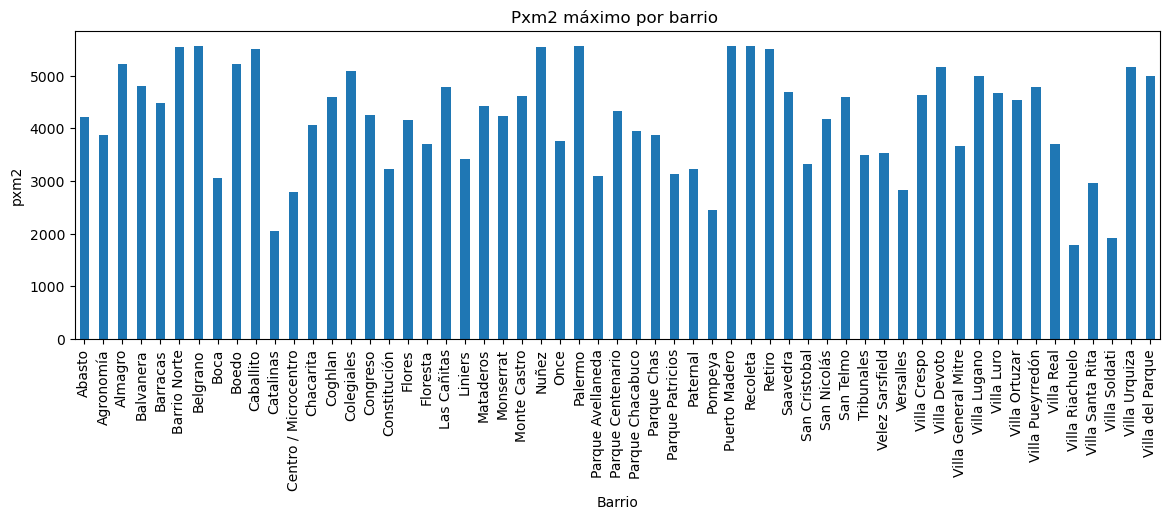

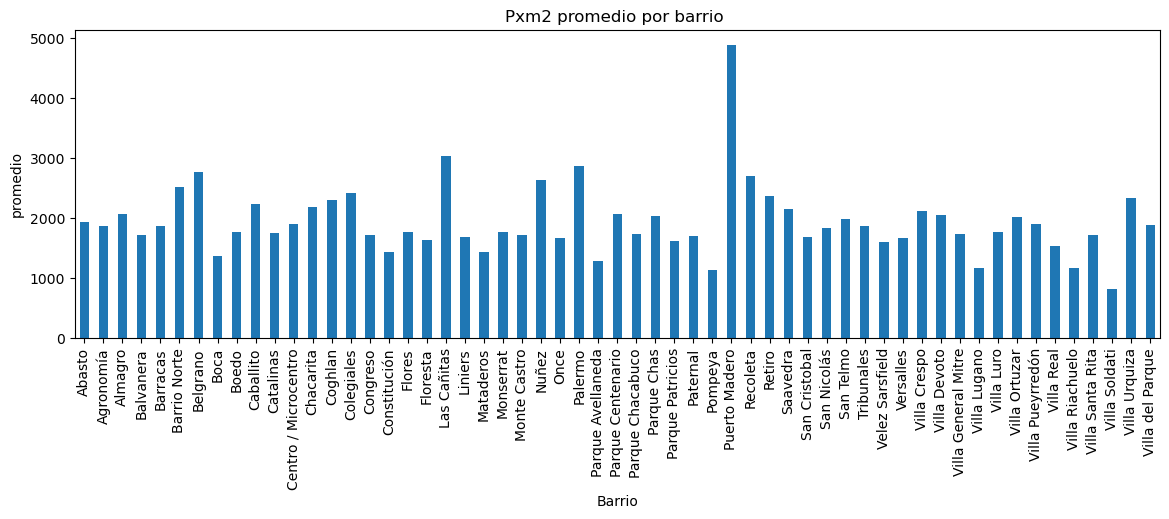

In [7]:
df_tprecio['pxm2'] = df_tprecio.apply(lambda row: corregir_pxm2(row['pxm2'], row['place_l3']), axis=1)

# Verificamos que los máximos de cada barrio estén más normalizados

plt.rcParams['figure.figsize'] = (14,4)
df_tprecio.groupby(by=['place_l3'])['pxm2'].max().plot.bar(alpha=1 , title="Pxm2 máximo por barrio " , xlabel="Barrio" , ylabel="pxm2")
plt.show()

promedios_por_barrio = df_tprecio.groupby(by=['place_l3'])['pxm2'].mean()
promedios_por_barrio.plot.bar(alpha=1 , title="Pxm2 promedio por barrio " , xlabel="Barrio" , ylabel="promedio")
plt.show()

### Dividir la variable pxm2 en 3 intervalos con igual cantidad de observaciones.

In [8]:
df_tprecio1 = df_tprecio.copy()

In [9]:
df_tprecio1["tipo_precio"] = pd.qcut( df_tprecio1["pxm2"],
                            q=3, # Separo en tres categorias iguales
                            labels=["bajo", "medio", "alto"])

df_tprecio1

latitud   longitud              place_l3 property_type  \
0     -34.589974 -58.459133               Palermo          Casa   
1     -34.637319 -58.361124                  Boca  Departamento   
2     -34.628647 -58.361871                  Boca  Departamento   
3     -34.610027 -58.401934                  Once  Departamento   
4     -34.631621 -58.416825                 Boedo            PH   
...          ...        ...                   ...           ...   
82658 -34.603245 -58.489810      Villa del Parque  Departamento   
82659 -34.614063 -58.482814      Villa del Parque  Departamento   
82660 -34.614175 -58.479062      Villa del Parque  Departamento   
82661 -34.614175 -58.479062      Villa del Parque  Departamento   
82662 -34.599790 -58.373411  Centro / Microcentro  Departamento   

       property_rooms  property_bedrooms  property_surface_total  \
0                   4                  3              171.000000   
1                   3                  2               58.000000   
2                   4                  3               70.000000   
3                   4                  2              135.327513   
4                   4                  2              106.415511   
...               ...                ...                     ...   
82658               4                  3              130.000000   
82659               3                  2               68.000000   
82660               1                  1               51.000000   
82661               1                  1               37.000000   
82662               2                  1               84.000000   

       property_surface_covered  property_price    pxm2 tipo_precio  
0                         133.0        210000.0  1228.0        bajo  
1                          55.0         82900.0  1429.0        bajo  
2                          70.0         99000.0  1414.0        bajo  
3                         104.0        146000.0  1079.0        bajo  
4                          73.0        250000.0  2349.0       medio  
...                         ...             ...     ...         ...  
82658                     100.0        220000.0  1692.0        bajo  
82659                      60.0        161000.0  2368.0       medio  
82660                      30.0         75500.0  1480.0        bajo  
82661                      31.0         74500.0  2014.0       medio  
82662                      84.0        135000.0  1607.0        bajo  

[82663 rows x 11 columns]

Verifico que se haya separado (aproximadamente) en partes iguales

In [10]:
df_tprecio1["tipo_precio"].value_counts()

medio    27564
bajo     27558
alto     27541
Name: tipo_precio, dtype: int64

### Dividir la variable pxm2 en 3 intervalos, el primero con el 25% de las observaciones, el siguiente con el 50% y el ultimo con el 25% de las observaciones restantes.

In [11]:
df_tprecio2 = df_tprecio.copy()

In [12]:
df_tprecio2["tipo_precio"] = pd.qcut( df_tprecio2["pxm2"],
                            [0, .25, .75, 1],
                            labels=["bajo", "medio", "alto"])

df_tprecio2

latitud   longitud              place_l3 property_type  \
0     -34.589974 -58.459133               Palermo          Casa   
1     -34.637319 -58.361124                  Boca  Departamento   
2     -34.628647 -58.361871                  Boca  Departamento   
3     -34.610027 -58.401934                  Once  Departamento   
4     -34.631621 -58.416825                 Boedo            PH   
...          ...        ...                   ...           ...   
82658 -34.603245 -58.489810      Villa del Parque  Departamento   
82659 -34.614063 -58.482814      Villa del Parque  Departamento   
82660 -34.614175 -58.479062      Villa del Parque  Departamento   
82661 -34.614175 -58.479062      Villa del Parque  Departamento   
82662 -34.599790 -58.373411  Centro / Microcentro  Departamento   

       property_rooms  property_bedrooms  property_surface_total  \
0                   4                  3              171.000000   
1                   3                  2               58.000000   
2                   4                  3               70.000000   
3                   4                  2              135.327513   
4                   4                  2              106.415511   
...               ...                ...                     ...   
82658               4                  3              130.000000   
82659               3                  2               68.000000   
82660               1                  1               51.000000   
82661               1                  1               37.000000   
82662               2                  1               84.000000   

       property_surface_covered  property_price    pxm2 tipo_precio  
0                         133.0        210000.0  1228.0        bajo  
1                          55.0         82900.0  1429.0        bajo  
2                          70.0         99000.0  1414.0        bajo  
3                         104.0        146000.0  1079.0        bajo  
4                          73.0        250000.0  2349.0       medio  
...                         ...             ...     ...         ...  
82658                     100.0        220000.0  1692.0        bajo  
82659                      60.0        161000.0  2368.0       medio  
82660                      30.0         75500.0  1480.0        bajo  
82661                      31.0         74500.0  2014.0       medio  
82662                      84.0        135000.0  1607.0        bajo  

[82663 rows x 11 columns]

In [13]:
df_tprecio2["tipo_precio"].value_counts()

medio    41404
bajo     20696
alto     20563
Name: tipo_precio, dtype: int64

La categoria "medio" representa el 50% de las observaciones, mientras que tanto "bajo" como "alto" posee un 25% cada una.

### Trabajar la variable pxm2 relativa a cada tipo de propiedad y luego dividirla como en el punto anterior.

In [14]:
df_tprecio3 = df_tprecio.copy()

In [15]:
df_tprecio3["tipo_precio"] = df_tprecio3.groupby("property_type").apply(
                            lambda propiedad: 
                                pd.qcut(propiedad['pxm2'], 
                                [0, .25, .75, 1], 
                                labels=["bajo", "medio", "alto"]
                            )).reset_index(drop=True)

df_tprecio3

latitud   longitud              place_l3 property_type  \
0     -34.589974 -58.459133               Palermo          Casa   
1     -34.637319 -58.361124                  Boca  Departamento   
2     -34.628647 -58.361871                  Boca  Departamento   
3     -34.610027 -58.401934                  Once  Departamento   
4     -34.631621 -58.416825                 Boedo            PH   
...          ...        ...                   ...           ...   
82658 -34.603245 -58.489810      Villa del Parque  Departamento   
82659 -34.614063 -58.482814      Villa del Parque  Departamento   
82660 -34.614175 -58.479062      Villa del Parque  Departamento   
82661 -34.614175 -58.479062      Villa del Parque  Departamento   
82662 -34.599790 -58.373411  Centro / Microcentro  Departamento   

       property_rooms  property_bedrooms  property_surface_total  \
0                   4                  3              171.000000   
1                   3                  2               58.000000   
2                   4                  3               70.000000   
3                   4                  2              135.327513   
4                   4                  2              106.415511   
...               ...                ...                     ...   
82658               4                  3              130.000000   
82659               3                  2               68.000000   
82660               1                  1               51.000000   
82661               1                  1               37.000000   
82662               2                  1               84.000000   

       property_surface_covered  property_price    pxm2 tipo_precio  
0                         133.0        210000.0  1228.0       medio  
1                          55.0         82900.0  1429.0       medio  
2                          70.0         99000.0  1414.0       medio  
3                         104.0        146000.0  1079.0        alto  
4                          73.0        250000.0  2349.0       medio  
...                         ...             ...     ...         ...  
82658                     100.0        220000.0  1692.0       medio  
82659                      60.0        161000.0  2368.0        alto  
82660                      30.0         75500.0  1480.0        alto  
82661                      31.0         74500.0  2014.0        alto  
82662                      84.0        135000.0  1607.0        alto  

[82663 rows x 11 columns]

In [16]:
df_tprecio3["tipo_precio"].value_counts()

medio    41279
bajo     20719
alto     20665
Name: tipo_precio, dtype: int64

# Ejercicio 3a

### Mostrar la distribucion del precio por metro cuadrado.

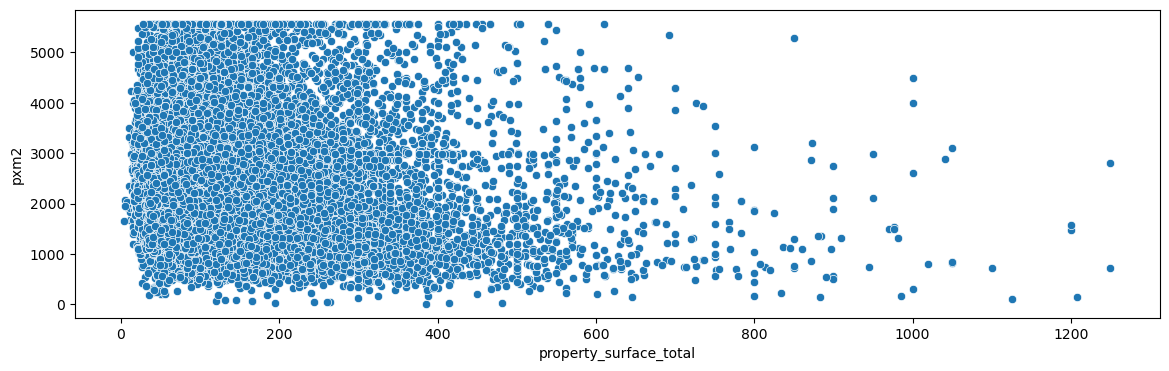

In [17]:
sns.scatterplot(data=df_tprecio1, x='property_surface_total', y="pxm2") 
plt.show()

Distribución dividiendo el precio por metro cuadrado en partes iguales.

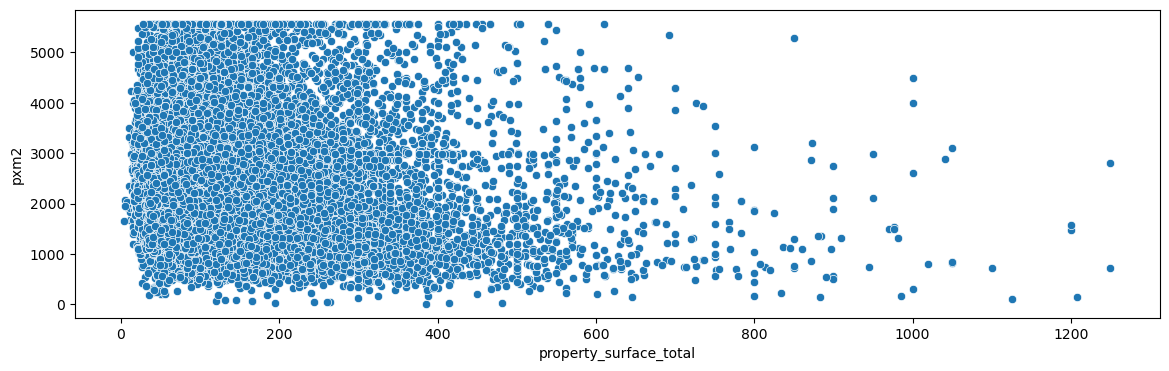

In [18]:
sns.scatterplot(data=df_tprecio2, x='property_surface_total', y="pxm2") 
plt.show()

Distrubución 25% bajo, 50% medio, 25% alto.

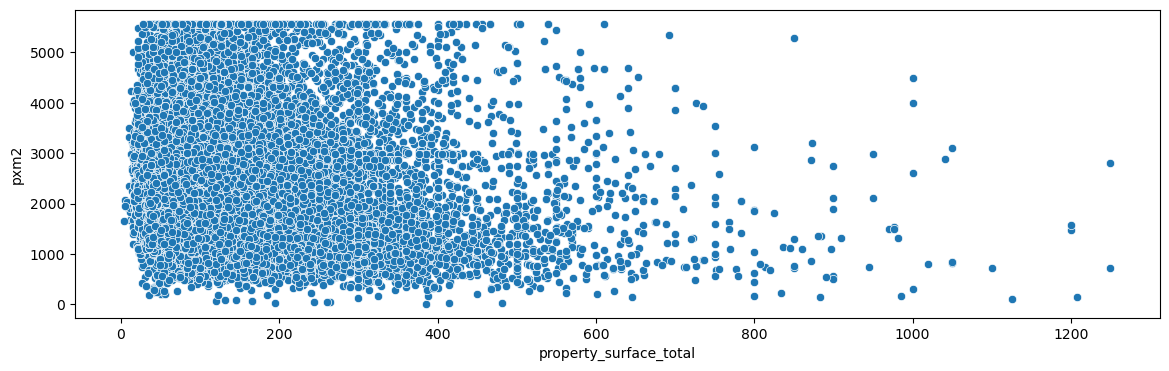

In [19]:
sns.scatterplot(data=df_tprecio3, x='property_surface_total', y="pxm2") 
plt.show()

Distribucion agrupando previamente por tipo de propiedad, se observa como se mezclan las categorias a diferencia de los dos casos anteriores.

### Mostrar la distribucion del precio por metro cuadrado por tipo de propiedad

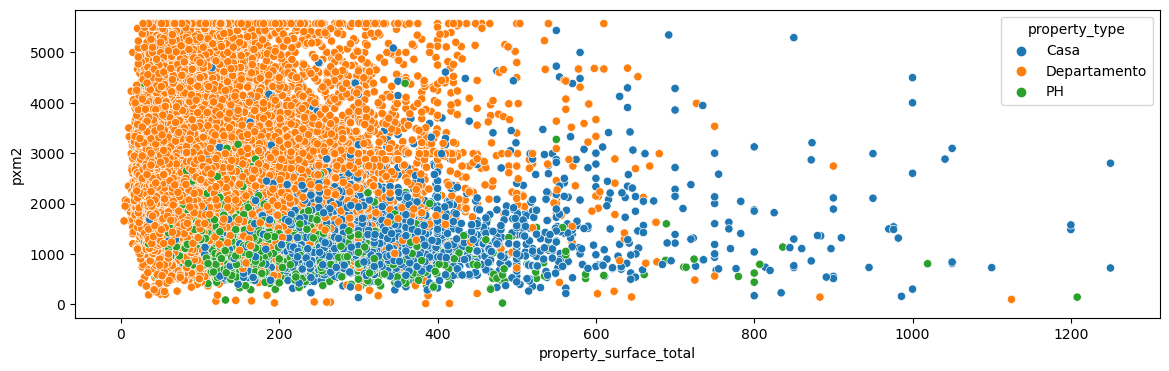

In [20]:
sns.scatterplot(data=df_tprecio1, x='property_surface_total', y="pxm2", hue="property_type")
plt.show() 

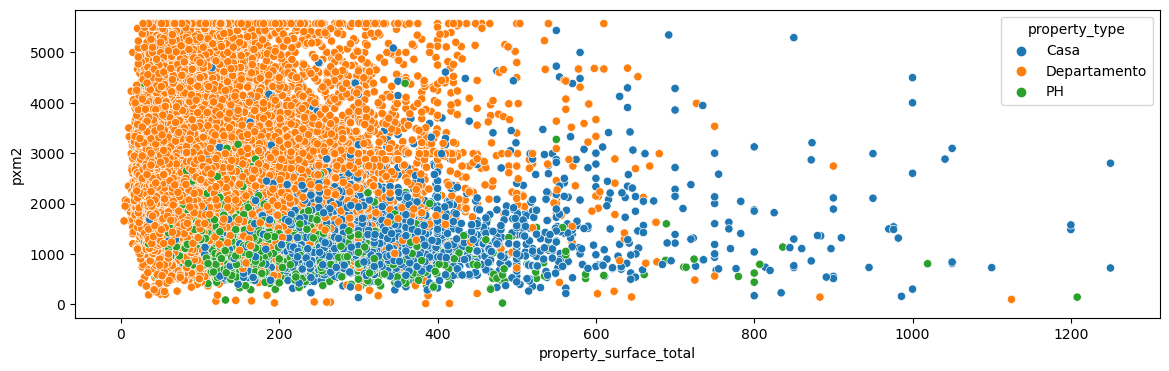

In [21]:
sns.scatterplot(data=df_tprecio2, x='property_surface_total', y="pxm2", hue="property_type")
plt.show()

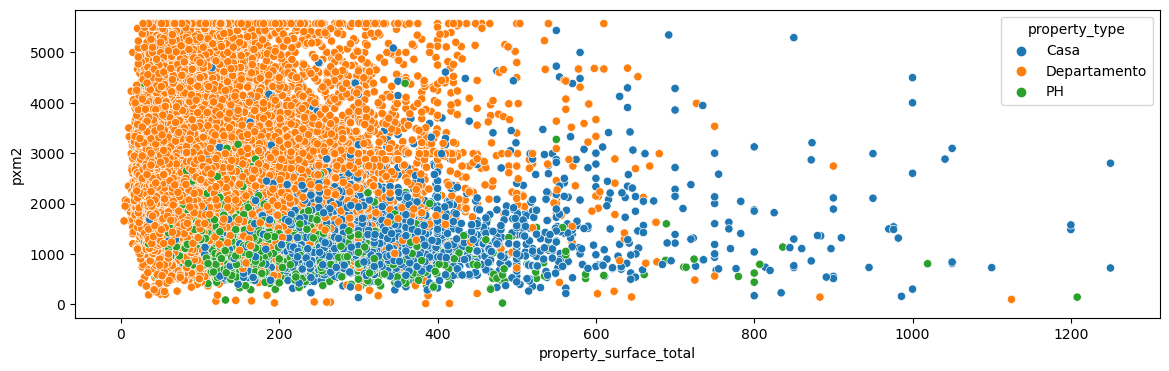

In [22]:
sns.scatterplot(data=df_tprecio3, x='property_surface_total', y="pxm2", hue="property_type") 
plt.show()

### Por cada una de las tres alternativas mostrar graficamente la distribución de la nueva variable creada tipo_precio

Agrupamiento en tres partes iguales

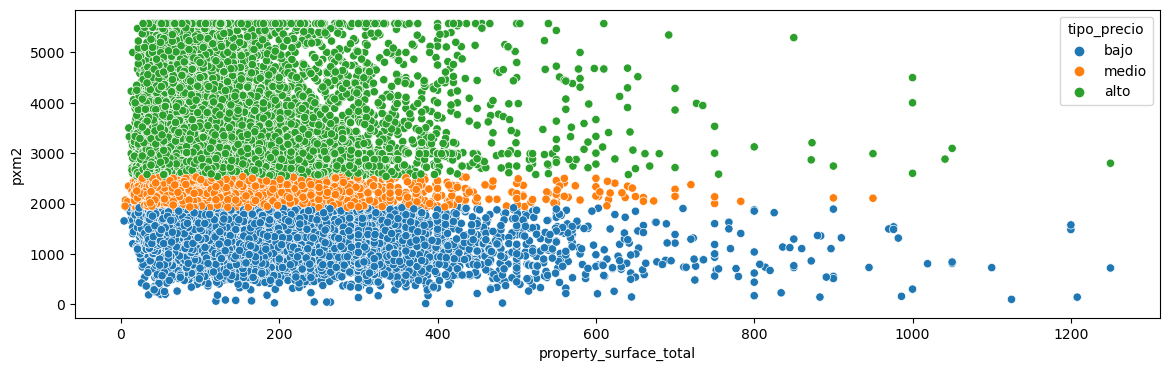

In [23]:
sns.scatterplot(data=df_tprecio1, x='property_surface_total', y="pxm2", hue="tipo_precio") 
plt.show()

Agrupamiento en tres partes, primera y ultima con 25% cada una, parte del medio con 50%

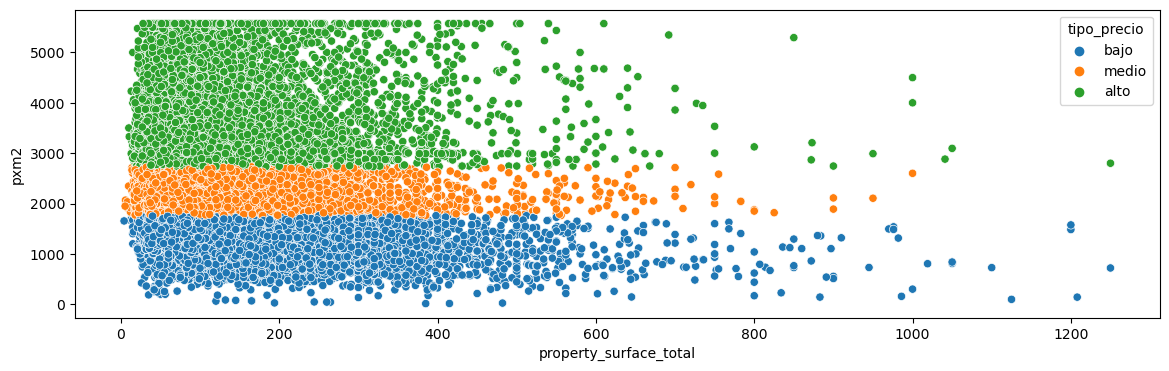

In [24]:
sns.scatterplot(data=df_tprecio2, x='property_surface_total', y="pxm2", hue="tipo_precio") 
plt.show()

Agrupamiento primero por tipo de propiedad, luego como en el item anterior

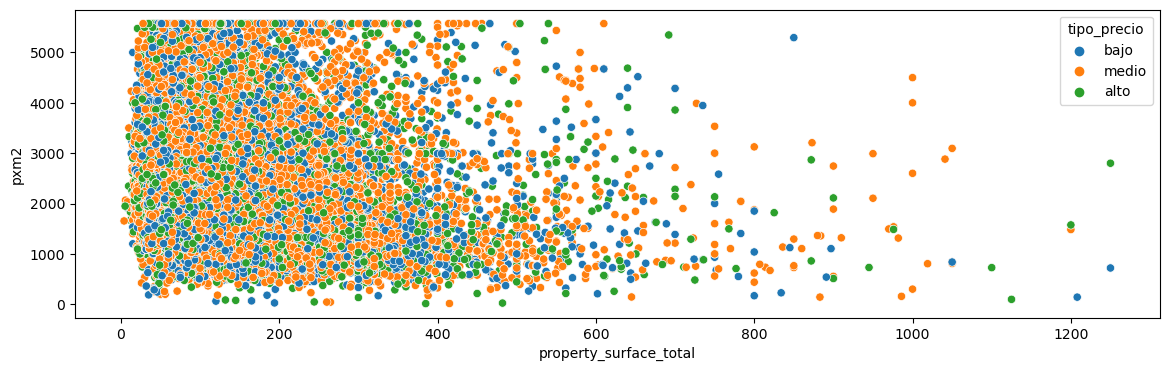

In [25]:
sns.scatterplot(data=df_tprecio3, x='property_surface_total', y="pxm2", hue="tipo_precio") 
plt.show()

### Seleccionar una de las alternativas, justificando la misma

In [149]:
df_tprecio = df_tprecio2 
df_tprecio

latitud   longitud              place_l3 property_type  \
0     -34.589974 -58.459133               Palermo          Casa   
1     -34.637319 -58.361124                  Boca  Departamento   
2     -34.628647 -58.361871                  Boca  Departamento   
3     -34.610027 -58.401934                  Once  Departamento   
4     -34.631621 -58.416825                 Boedo            PH   
...          ...        ...                   ...           ...   
82658 -34.603245 -58.489810      Villa del Parque  Departamento   
82659 -34.614063 -58.482814      Villa del Parque  Departamento   
82660 -34.614175 -58.479062      Villa del Parque  Departamento   
82661 -34.614175 -58.479062      Villa del Parque  Departamento   
82662 -34.599790 -58.373411  Centro / Microcentro  Departamento   

       property_rooms  property_bedrooms  property_surface_total  \
0                   4                  3              171.000000   
1                   3                  2               58.000000   
2                   4                  3               70.000000   
3                   4                  2              135.327513   
4                   4                  2              106.415511   
...               ...                ...                     ...   
82658               4                  3              130.000000   
82659               3                  2               68.000000   
82660               1                  1               51.000000   
82661               1                  1               37.000000   
82662               2                  1               84.000000   

       property_surface_covered  property_price    pxm2 tipo_precio  
0                         133.0        210000.0  1228.0        bajo  
1                          55.0         82900.0  1429.0        bajo  
2                          70.0         99000.0  1414.0        bajo  
3                         104.0        146000.0  1079.0        bajo  
4                          73.0        250000.0  2349.0       medio  
...                         ...             ...     ...         ...  
82658                     100.0        220000.0  1692.0        bajo  
82659                      60.0        161000.0  2368.0       medio  
82660                      30.0         75500.0  1480.0        bajo  
82661                      31.0         74500.0  2014.0       medio  
82662                      84.0        135000.0  1607.0        bajo  

[82663 rows x 11 columns]

Seleccionamos la segunda alternativa antes que la primera debido a que preferimos un agrupamiento equitativo (en cantidad), la tercer alternativa la descartamos ya que podemos notar que si primero agrupamos por propiedad y luego por tipo de precio obtenemos un resultado desordenado.

### Comparar, si aplica, la alternativa seleccionada con la division en 3 grupos obtenida utilizando agrupamiento por K Means

In [150]:
df_kmeans=pd.read_csv("./data/punto2.csv")

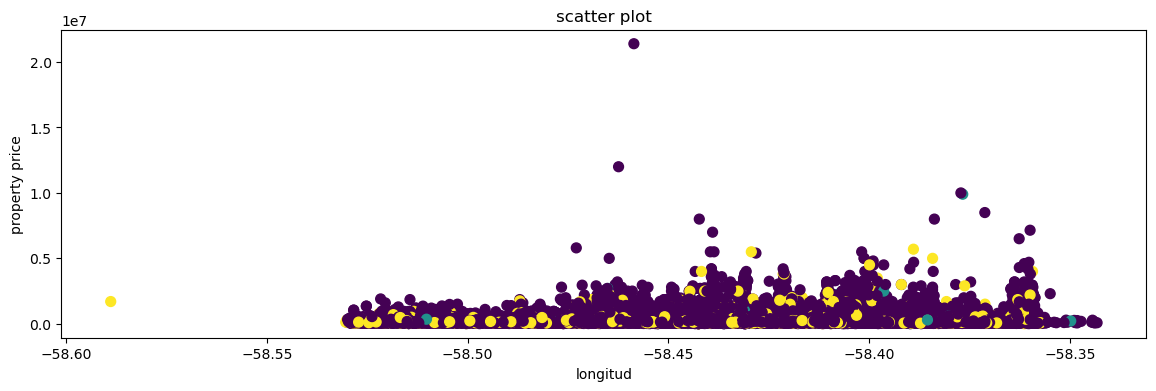

In [153]:
plt.scatter(df_kmeans.longitud, df_kmeans.property_price, c=df_kmeans.colores2, s=50, cmap='viridis')
plt.xlabel('longitud')
plt.ylabel('property price')
plt.title('scatter plot')
plt.show()

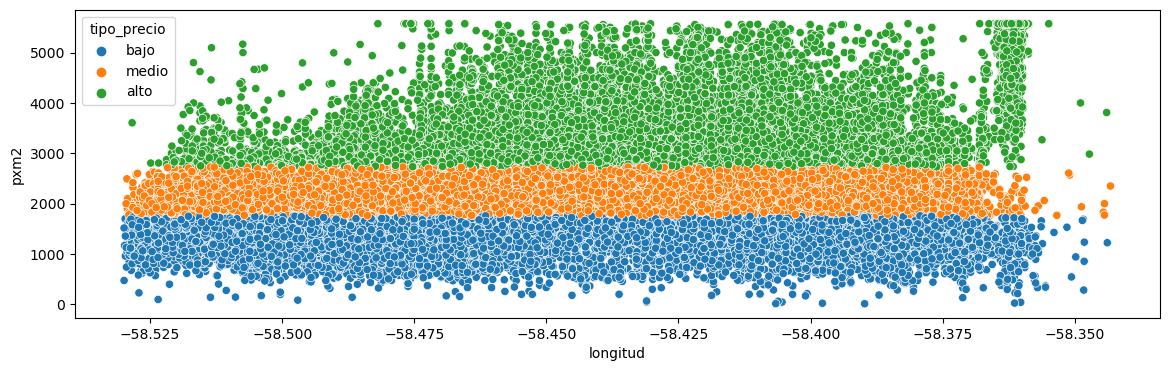

In [154]:
sns.scatterplot(data=df_tprecio, x='longitud', y="pxm2", hue="tipo_precio") 
plt.show()

Se pueden comparar con la alternativa seleccionada ya que, como en el gráfico de kmeans, se puede observar que mientras más a la derecha vas mayor porcentaje de precios altos hay, esto quiere decir que, en barrios como podría ser Palermo el precio por metro cuadrado y su precio real son más elevados que en otras zonas. 

### Mostrar en un mapa de CABA los avisos coloreados por tipo_precio

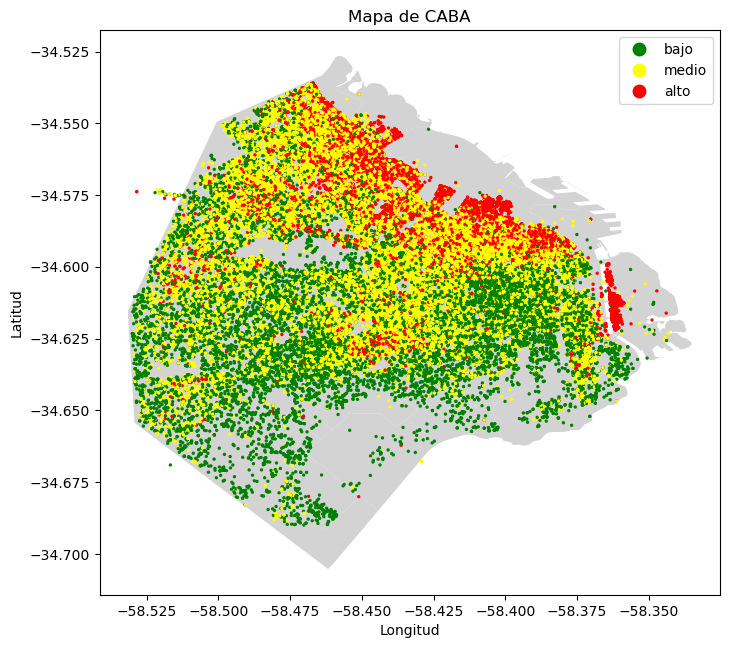

In [155]:
fig, ax = plt.subplots(figsize=(8,8))
barrios = gp.read_file("barrios.geojson")
ax.set_title('Mapa de CABA')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
barrios.plot(ax=ax,column='BARRIO', color='lightgrey')

color_dict = {'bajo':'green',  
              'medio':'yellow',
              'alto':'red' }

puntos = gp.GeoDataFrame(df_tprecio.tipo_precio, geometry=gp.points_from_xy(df_tprecio.longitud, df_tprecio.latitud))    
puntos.plot(ax = ax, column='tipo_precio', markersize=2, legend=True, 
            cmap=colors.ListedColormap(list(color_dict.values())))

plt.show()

# Ejercicio 3b

Entrenamiento y predicción. Predecir el valor del atributo tipo_precio, excluyendo del entrenamiento la variable price, pxm2, y cualquier otra variable que pueda contener información del precio de venta.

Realizar las tareas de ingeniería de características necesarias para trabajar con cada algoritmos (encoding, normalización, etc).

In [31]:
df_EyP=df_tprecio.copy()

In [32]:
df_EyP.dtypes

latitud                      float64
longitud                     float64
place_l3                      object
property_type                 object
property_rooms                 int64
property_bedrooms              int64
property_surface_total       float64
property_surface_covered     float64
property_price               float64
pxm2                         float64
tipo_precio                 category
dtype: object

Quito variables indicativas del precio de venta:

In [33]:
df_EyP.drop(['property_price', 'pxm2'], axis=1, inplace=True)

## Modelo 1 - Árbol de decisión

### Metricas

- **Accuracy:**
El calculo de la precisión de una clasificacion mide la cantidad de casos verdaderos acertados en base al total de casos detectados.

- **Recall:** 
Calcula la cantidad de casos verdaderos acertados en base a la totalidad de casos detectados, debido a que nuestro analisis es multiclase, debemos utilizar una de las siguientes medidas:
- Macro-recall: promedio del recall score de cada clase.
- Weighted-recall: ponderado del recall score de cada clase.
- Micro-recall: precisión general del modelo.

- **f1 score:**
Combinación de las medidas de precisión y recall en un sólo valor, debido a que nuestro analisis es multiclase, debemos utilizar una de las siguientes medidas:
- Macro-f1: promedio del f1 score de cada clase.
- Weighted-f1: ponderado del f1 score de cada clase.
- Micro-f1: el valor de Micro-recall.

En este caso utilizaremos Weigthed-recall y Weighted-f1

### Ajuste del dataset 

Creamos una copia del dataset del punto 1d:

In [34]:
df_dTree=df_EyP.copy()

Transformo variables categoricas para poder utilizarlas como predictorias

In [35]:
df_dTree = pd.get_dummies(df_dTree, columns=["place_l3","property_type"], drop_first=True)
df_dTree.head()

latitud   longitud  property_rooms  property_bedrooms  \
0 -34.589974 -58.459133               4                  3   
1 -34.637319 -58.361124               3                  2   
2 -34.628647 -58.361871               4                  3   
3 -34.610027 -58.401934               4                  2   
4 -34.631621 -58.416825               4                  2   

   property_surface_total  property_surface_covered tipo_precio  \
0              171.000000                     133.0        bajo   
1               58.000000                      55.0        bajo   
2               70.000000                      70.0        bajo   
3              135.327513                     104.0        bajo   
4              106.415511                      73.0       medio   

   place_l3_Agronomía  place_l3_Almagro  place_l3_Balvanera  ...  \
0                   0                 0                   0  ...   
1                   0                 0                   0  ...   
2                   0                 0                   0  ...   
3                   0                 0                   0  ...   
4                   0                 0                   0  ...   

   place_l3_Villa Ortuzar  place_l3_Villa Pueyrredón  place_l3_Villa Real  \
0                       0                          0                    0   
1                       0                          0                    0   
2                       0                          0                    0   
3                       0                          0                    0   
4                       0                          0                    0   

   place_l3_Villa Riachuelo  place_l3_Villa Santa Rita  \
0                         0                          0   
1                         0                          0   
2                         0                          0   
3                         0                          0   
4                         0                          0   

   place_l3_Villa Soldati  place_l3_Villa Urquiza  place_l3_Villa del Parque  \
0                       0                       0                          0   
1                       0                       0                          0   
2                       0                       0                          0   
3                       0                       0                          0   
4                       0                       0                          0   

   property_type_Departamento  property_type_PH  
0                           0                 0  
1                           1                 0  
2                           1                 0  
3                           1                 0  
4                           0                 1  

[5 rows x 65 columns]

Variables (features) que clasifican y variable (target) a la que quiero calcular

In [36]:
#Creo un dataset con los features que voy a usar para clasificar
df_dTree_x=df_dTree.drop(['tipo_precio'], axis='columns', inplace=False)

#Creo un dataset con la variable target
df_dTree_y = df_dTree['tipo_precio'].copy()

#Genero los conjuntos de train y test
x_train, x_test, y_train, y_test = train_test_split(df_dTree_x, 
                                                    df_dTree_y, 
                                                    test_size=0.2,  #proporcion 80/20
                                                    random_state=2)

### Prueba con el modelo sin optimización

In [37]:
arbolcv=DecisionTreeClassifier()

arbolcv.fit(x_train,y_train)

DecisionTreeClassifier()

In [38]:
arbolcv_entrenado = arbolcv.fit(X = x_train, y = y_train)
y_pred = arbolcv.predict(x_test)
y_pred

array(['alto', 'medio', 'medio', ..., 'bajo', 'medio', 'bajo'],
      dtype=object)

In [39]:
y_test.values

['alto', 'medio', 'medio', 'medio', 'alto', ..., 'medio', 'alto', 'medio', 'medio', 'medio']
Length: 16533
Categories (3, object): ['bajo' < 'medio' < 'alto']

In [40]:
y_pred = arbolcv.predict(x_test)
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred,average="weighted")
f1=f1_score(y_test,y_pred,average="weighted")

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

Accuracy: 0.6753765196878969
Recall: 0.6753765196878969
f1 score: 0.6756761192595572


In [41]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        alto       0.63      0.66      0.65      4016
        bajo       0.67      0.68      0.68      4183
       medio       0.70      0.68      0.69      8334

    accuracy                           0.68     16533
   macro avg       0.67      0.67      0.67     16533
weighted avg       0.68      0.68      0.68     16533



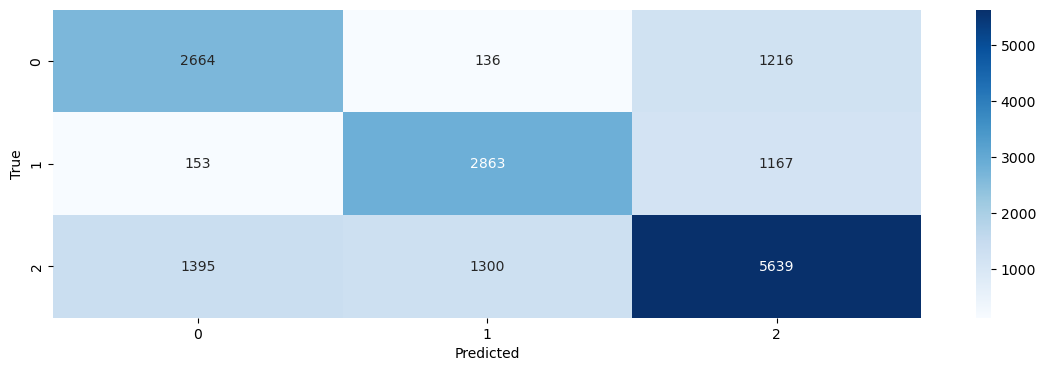

In [42]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

El modelo clasifica correctamente mas de lo que hace erroneamente.

### Optimización de hiperparametros

In [43]:
print(x_train.shape[0])

66130


La cantidad de entradas en nuestro conjunto de entrenamiento es de 66130, elejimos una cantidad de folds de manera tal que quede cada subconjunto con igual cantidad de entradas.

In [44]:
folds = 10

In [45]:
#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               'ccp_alpha':np.linspace(0,0.05,10), 
               'max_depth':list(range(1,16))}
                
#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

grid_search = GridSearchCV(
                estimator=base_tree,
                param_grid=params_grid, 
                cv = kfoldcv, 
                n_jobs = -1,
                return_train_score='True'
            )

grid_search.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': array([0.        , 0.00555556, 0.01111111, 0.01666667, 0.02222222,
       0.02777778, 0.03333333, 0.03888889, 0.04444444, 0.05      ]),
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15]},
             return_train_score='True')

In [46]:
#Mejores hiperparametros del arbol
print(grid_search.best_params_)
#Mejor métrica
print(grid_search.best_score_)

{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 15}
0.6693331317102678


Atributos considerados y su importancia

In [47]:
best_tree = grid_search.best_estimator_
feat_imps = best_tree.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,df_dTree.columns)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

place_l3_Villa Pueyrredón: 8.426006211283711e-05
place_l3_Caballito: 8.455879180269527e-05
place_l3_San Telmo: 9.143950505445625e-05
place_l3_Palermo: 0.00010933443562063096
place_l3_Coghlan: 0.00012227719355661446
place_l3_Villa General Mitre: 0.0001306253872966206
place_l3_Catalinas: 0.00014088719147072366
place_l3_Villa Riachuelo: 0.00014326570785011807
place_l3_Parque Patricios: 0.0001551909505823258
place_l3_Villa Urquiza: 0.00016174773960955137
place_l3_Villa Devoto: 0.0001712982909857358
place_l3_San Cristobal: 0.00019728675936575614
place_l3_Monserrat: 0.00022557370854329317
place_l3_Balvanera: 0.00028233135909750046
place_l3_Centro / Microcentro: 0.000304770026291404
place_l3_Las Cañitas: 0.00031639555614156864
place_l3_Boca: 0.0003215231738510644
place_l3_Villa Luro: 0.0003235025491084539
tipo_precio: 0.00034535547503952393
place_l3_Flores: 0.0003565454779956333
place_l3_Constitución: 0.00038854199072771136
place_l3_Parque Chacabuco: 0.00043691092749798634
place_l3_Tribunales

Nuestro atributo de mayor importancia es la latitud sobre la cual se ubica la propiedad.

### Construcción del árbol de decisión con mejores parametros

Creamos el árbol con los mejores hiperparametros obtenidos en el item anterior y lo entrenamos

In [48]:
arbolcv=DecisionTreeClassifier().set_params(**grid_search.best_params_)

arbolcv.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=15)

#### Grafico del árbol de decisión

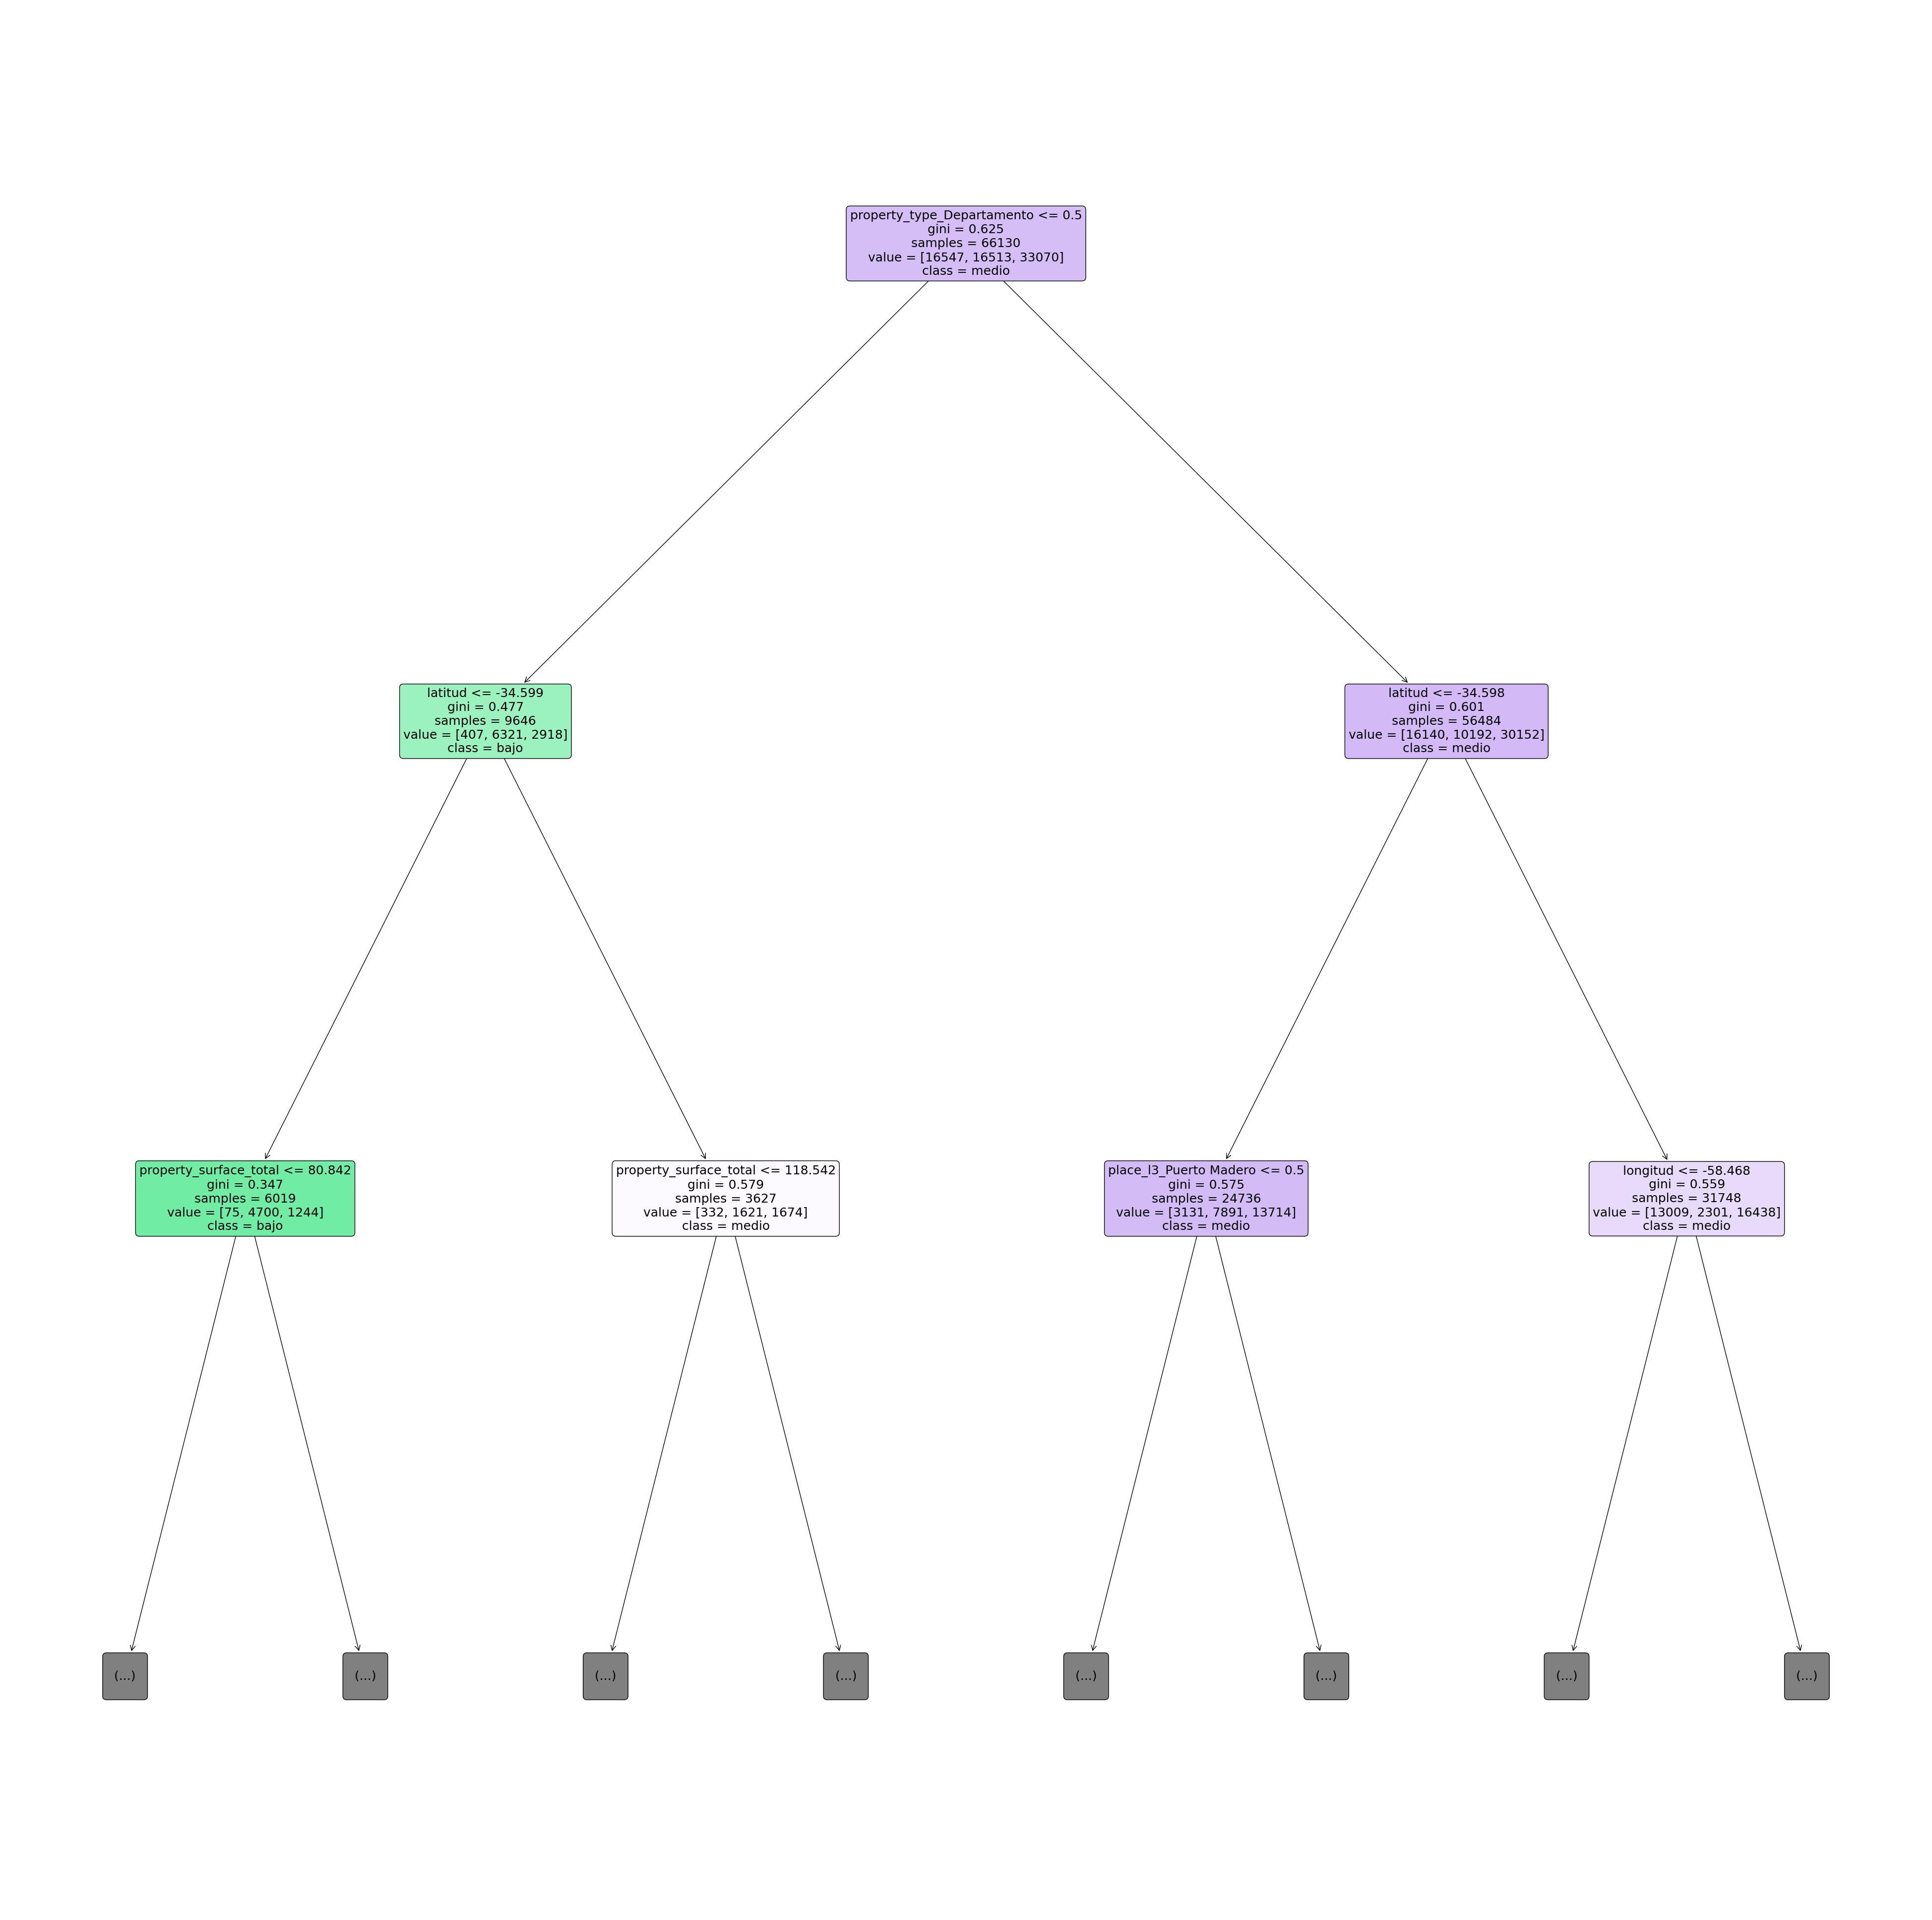

In [49]:
plt.figure(figsize=(50,50))

tree_plot=tree.plot_tree(arbolcv,
                        feature_names=x_train.columns.to_list(),
                        filled=True,
                        rounded=True,
                        max_depth=2,
                        class_names=['alto', 'bajo', 'medio'])
plt.show(tree_plot)

#### Analisis del árbol de decisión

In [50]:
reglas = export_text(arbolcv, feature_names=list(df_dTree_x))
print(reglas)

|--- property_type_Departamento <= 0.50
|   |--- latitud <= -34.60
|   |   |--- property_surface_total <= 80.84
|   |   |   |--- longitud <= -58.41
|   |   |   |   |--- latitud <= -34.62
|   |   |   |   |   |--- longitud <= -58.45
|   |   |   |   |   |   |--- longitud <= -58.50
|   |   |   |   |   |   |   |--- property_type_PH <= 0.50
|   |   |   |   |   |   |   |   |--- place_l3_Mataderos <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: bajo
|   |   |   |   |   |   |   |   |--- place_l3_Mataderos >  0.50
|   |   |   |   |   |   |   |   |   |--- class: medio
|   |   |   |   |   |   |   |--- property_type_PH >  0.50
|   |   |   |   |   |   |   |   |--- property_surface_covered <= 39.50
|   |   |   |   |   |   |   |   |   |--- property_surface_total <= 53.00
|   |   |   |   |   |   |   |   |   |   |--- property_surface_covered <= 35.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |   |--- property_surface_covered 

El criterio principal de categorización es el de la latitud, zona norte o zona sur de CABA, los departamentos de zona norte son considerados de tipo de precio alto si se ubican cercanas al rio (Belgrano, Palermo, etc) y de precio medio en caso contrario. Los departamentos de zona sur son de precio alto si se encuentran dentro de Puerto Madero. Los PH y Casas de zona sur son de precio bajo, mientras que las de zona norte son de precio medio.

### Evaluación de la performance del árbol en el conjunto de evaluación

Entrenamos al modelo y vemos valores predichos

In [51]:
arbolcv_entrenado = arbolcv.fit(X = x_train, y = y_train)
y_pred = arbolcv.predict(x_test)
y_pred

array(['alto', 'medio', 'medio', ..., 'medio', 'medio', 'bajo'],
      dtype=object)

Valores reales

In [52]:
y_test.values

['alto', 'medio', 'medio', 'medio', 'alto', ..., 'medio', 'alto', 'medio', 'medio', 'medio']
Length: 16533
Categories (3, object): ['bajo' < 'medio' < 'alto']

Evaluación performance en el conjunto de evaluación.

In [53]:
y_pred = arbolcv.predict(x_test)
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred,average="weighted")
f1=f1_score(y_test,y_pred,average="weighted")

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

Accuracy: 0.6695094659166515
Recall: 0.6695094659166515
f1 score: 0.6656083949211599


In [54]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        alto       0.65      0.53      0.58      4016
        bajo       0.73      0.61      0.66      4183
       medio       0.65      0.77      0.71      8334

    accuracy                           0.67     16533
   macro avg       0.68      0.63      0.65     16533
weighted avg       0.67      0.67      0.67     16533



Matriz de confusión

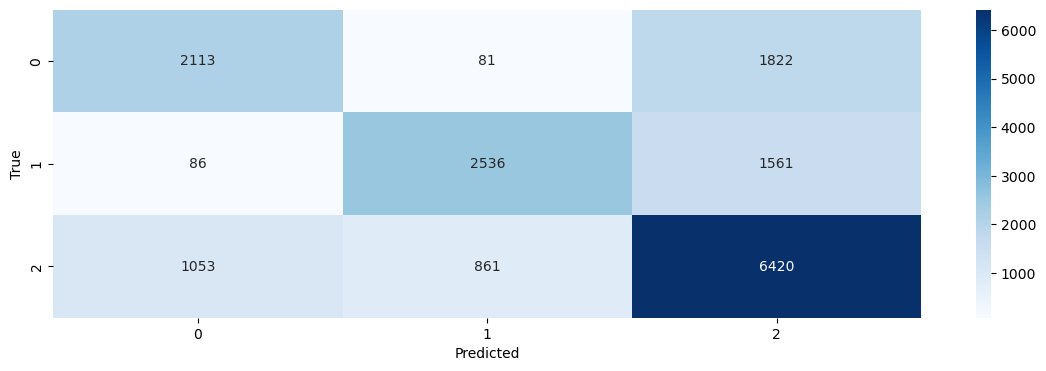

In [55]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Agregar explicación de la matriz.

### Entrenamiento con PCA

#### Ajuste del dataset

In [56]:
df_EyP_pca=pd.read_csv('./data/properati_argentina_2021_pca.csv')
df_EyP_pca.dtypes

Unnamed: 0      int64
cp_1          float64
cp_2          float64
cp_3          float64
cp_4          float64
dtype: object

Agregamos columna tipo_precio  al dataset

In [57]:
df_EyP_pca["tipo_precio"] = df_EyP["tipo_precio"]
df_EyP_pca.drop("Unnamed: 0",axis=1, inplace=True) # Unnamed: 0 se saca guardando el csv sin indice -> df.to_csv(path, index=False)
df_EyP_pca.head(5)

cp_1      cp_2      cp_3      cp_4 tipo_precio
0  1.723874  0.442462 -0.595169 -0.399147        bajo
1 -0.425314 -2.594847  0.391853 -0.452189        bajo
2  0.525134 -2.423912  0.245152 -1.205362        bajo
3  0.804044 -1.093447  0.155028 -0.378132        bajo
4  0.536067 -1.437797 -0.418144  0.089356       medio

In [58]:
# El dataset probablemente tenga valores nan porque no se corre hace mucho
df_EyP_pca.dropna(inplace=True)
df_EyP_pca.isna().sum()

cp_1           0
cp_2           0
cp_3           0
cp_4           0
tipo_precio    0
dtype: int64

In [59]:
#Creo un dataset con los features que voy a usar para clasificar
df_dTree_x=df_EyP_pca.drop(['tipo_precio'], axis='columns', inplace=False)

#Creo un dataset con la variable target
df_dTree_y = df_EyP_pca['tipo_precio'].copy()

#Genero los conjuntos de train y test
x_train, x_test, y_train, y_test = train_test_split(df_dTree_x, 
                                                    df_dTree_y, 
                                                    test_size=0.2,  #proporcion 80/20
                                                    random_state=2)

#### Prueba con el modelo sin optimización

In [60]:
arbolcv=DecisionTreeClassifier()

arbolcv.fit(x_train,y_train)

DecisionTreeClassifier()

In [61]:
arbolcv_entrenado = arbolcv.fit(X = x_train, y = y_train)
y_pred = arbolcv.predict(x_test)
y_pred

array(['medio', 'medio', 'bajo', ..., 'medio', 'bajo', 'alto'],
      dtype=object)

In [62]:
y_test.values

['alto', 'bajo', 'medio', 'medio', 'medio', ..., 'alto', 'bajo', 'medio', 'medio', 'bajo']
Length: 16529
Categories (3, object): ['bajo' < 'medio' < 'alto']

In [63]:
y_pred = arbolcv.predict(x_test)
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred,average="weighted")
f1=f1_score(y_test,y_pred,average="weighted")

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

Accuracy: 0.39421622602698286
Recall: 0.39421622602698286
f1 score: 0.39583197213708493


In [64]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        alto       0.29      0.30      0.30      4095
        bajo       0.29      0.30      0.30      4177
       medio       0.50      0.49      0.50      8257

    accuracy                           0.39     16529
   macro avg       0.36      0.36      0.36     16529
weighted avg       0.40      0.39      0.40     16529



Podemos observar que inicialmente la performance del modelo PCA es drasticamente peor que el del dataset con sus dimensiones no reducidas.

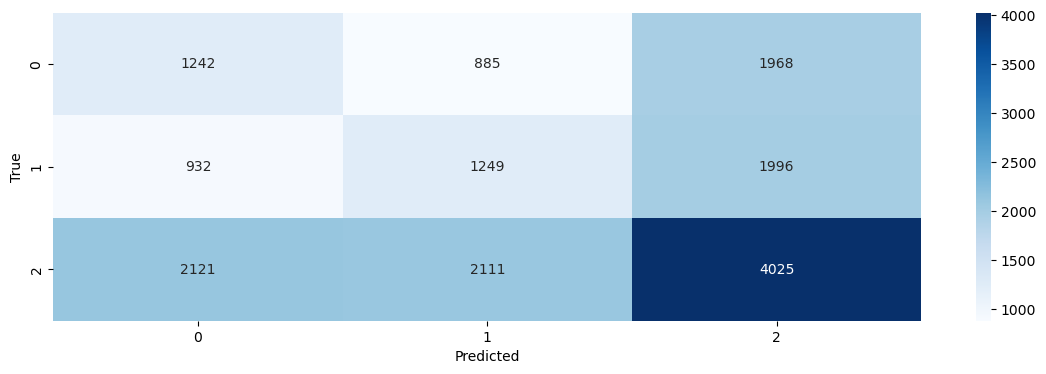

In [65]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### Optimización de hiperparametros

In [66]:
folds = 10

In [67]:
#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               'ccp_alpha':np.linspace(0,0.05,10), 
               'max_depth':list(range(1,16))}
                
#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

grid_search = GridSearchCV(
                estimator=base_tree,
                param_grid=params_grid, 
                cv = kfoldcv, 
                n_jobs = -1,
                return_train_score='True'
            )

grid_search.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': array([0.        , 0.00555556, 0.01111111, 0.01666667, 0.02222222,
       0.02777778, 0.03333333, 0.03888889, 0.04444444, 0.05      ]),
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15]},
             return_train_score='True')

In [68]:
#Mejores hiperparametros del arbol
print(grid_search.best_params_)
#Mejor métrica
print(grid_search.best_score_)

{'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 5}
0.5034561524299589


In [69]:
best_tree = grid_search.best_estimator_
feat_imps = best_tree.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,df_EyP_pca.columns)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

cp_1: 0.05184743705037653
cp_4: 0.06374459345266369
cp_2: 0.2905337166391832
cp_3: 0.5938742528577766


Vemos que cp_3 es el atributo de mayor importancia.

#### Construcción del árbol de decisión

Creamos el árbol con los mejores hiperparametros obtenidos en el item anterior y lo entrenamos

In [70]:
arbolcv=DecisionTreeClassifier().set_params(**grid_search.best_params_)

arbolcv.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

#### Grafico del árbol de decisión

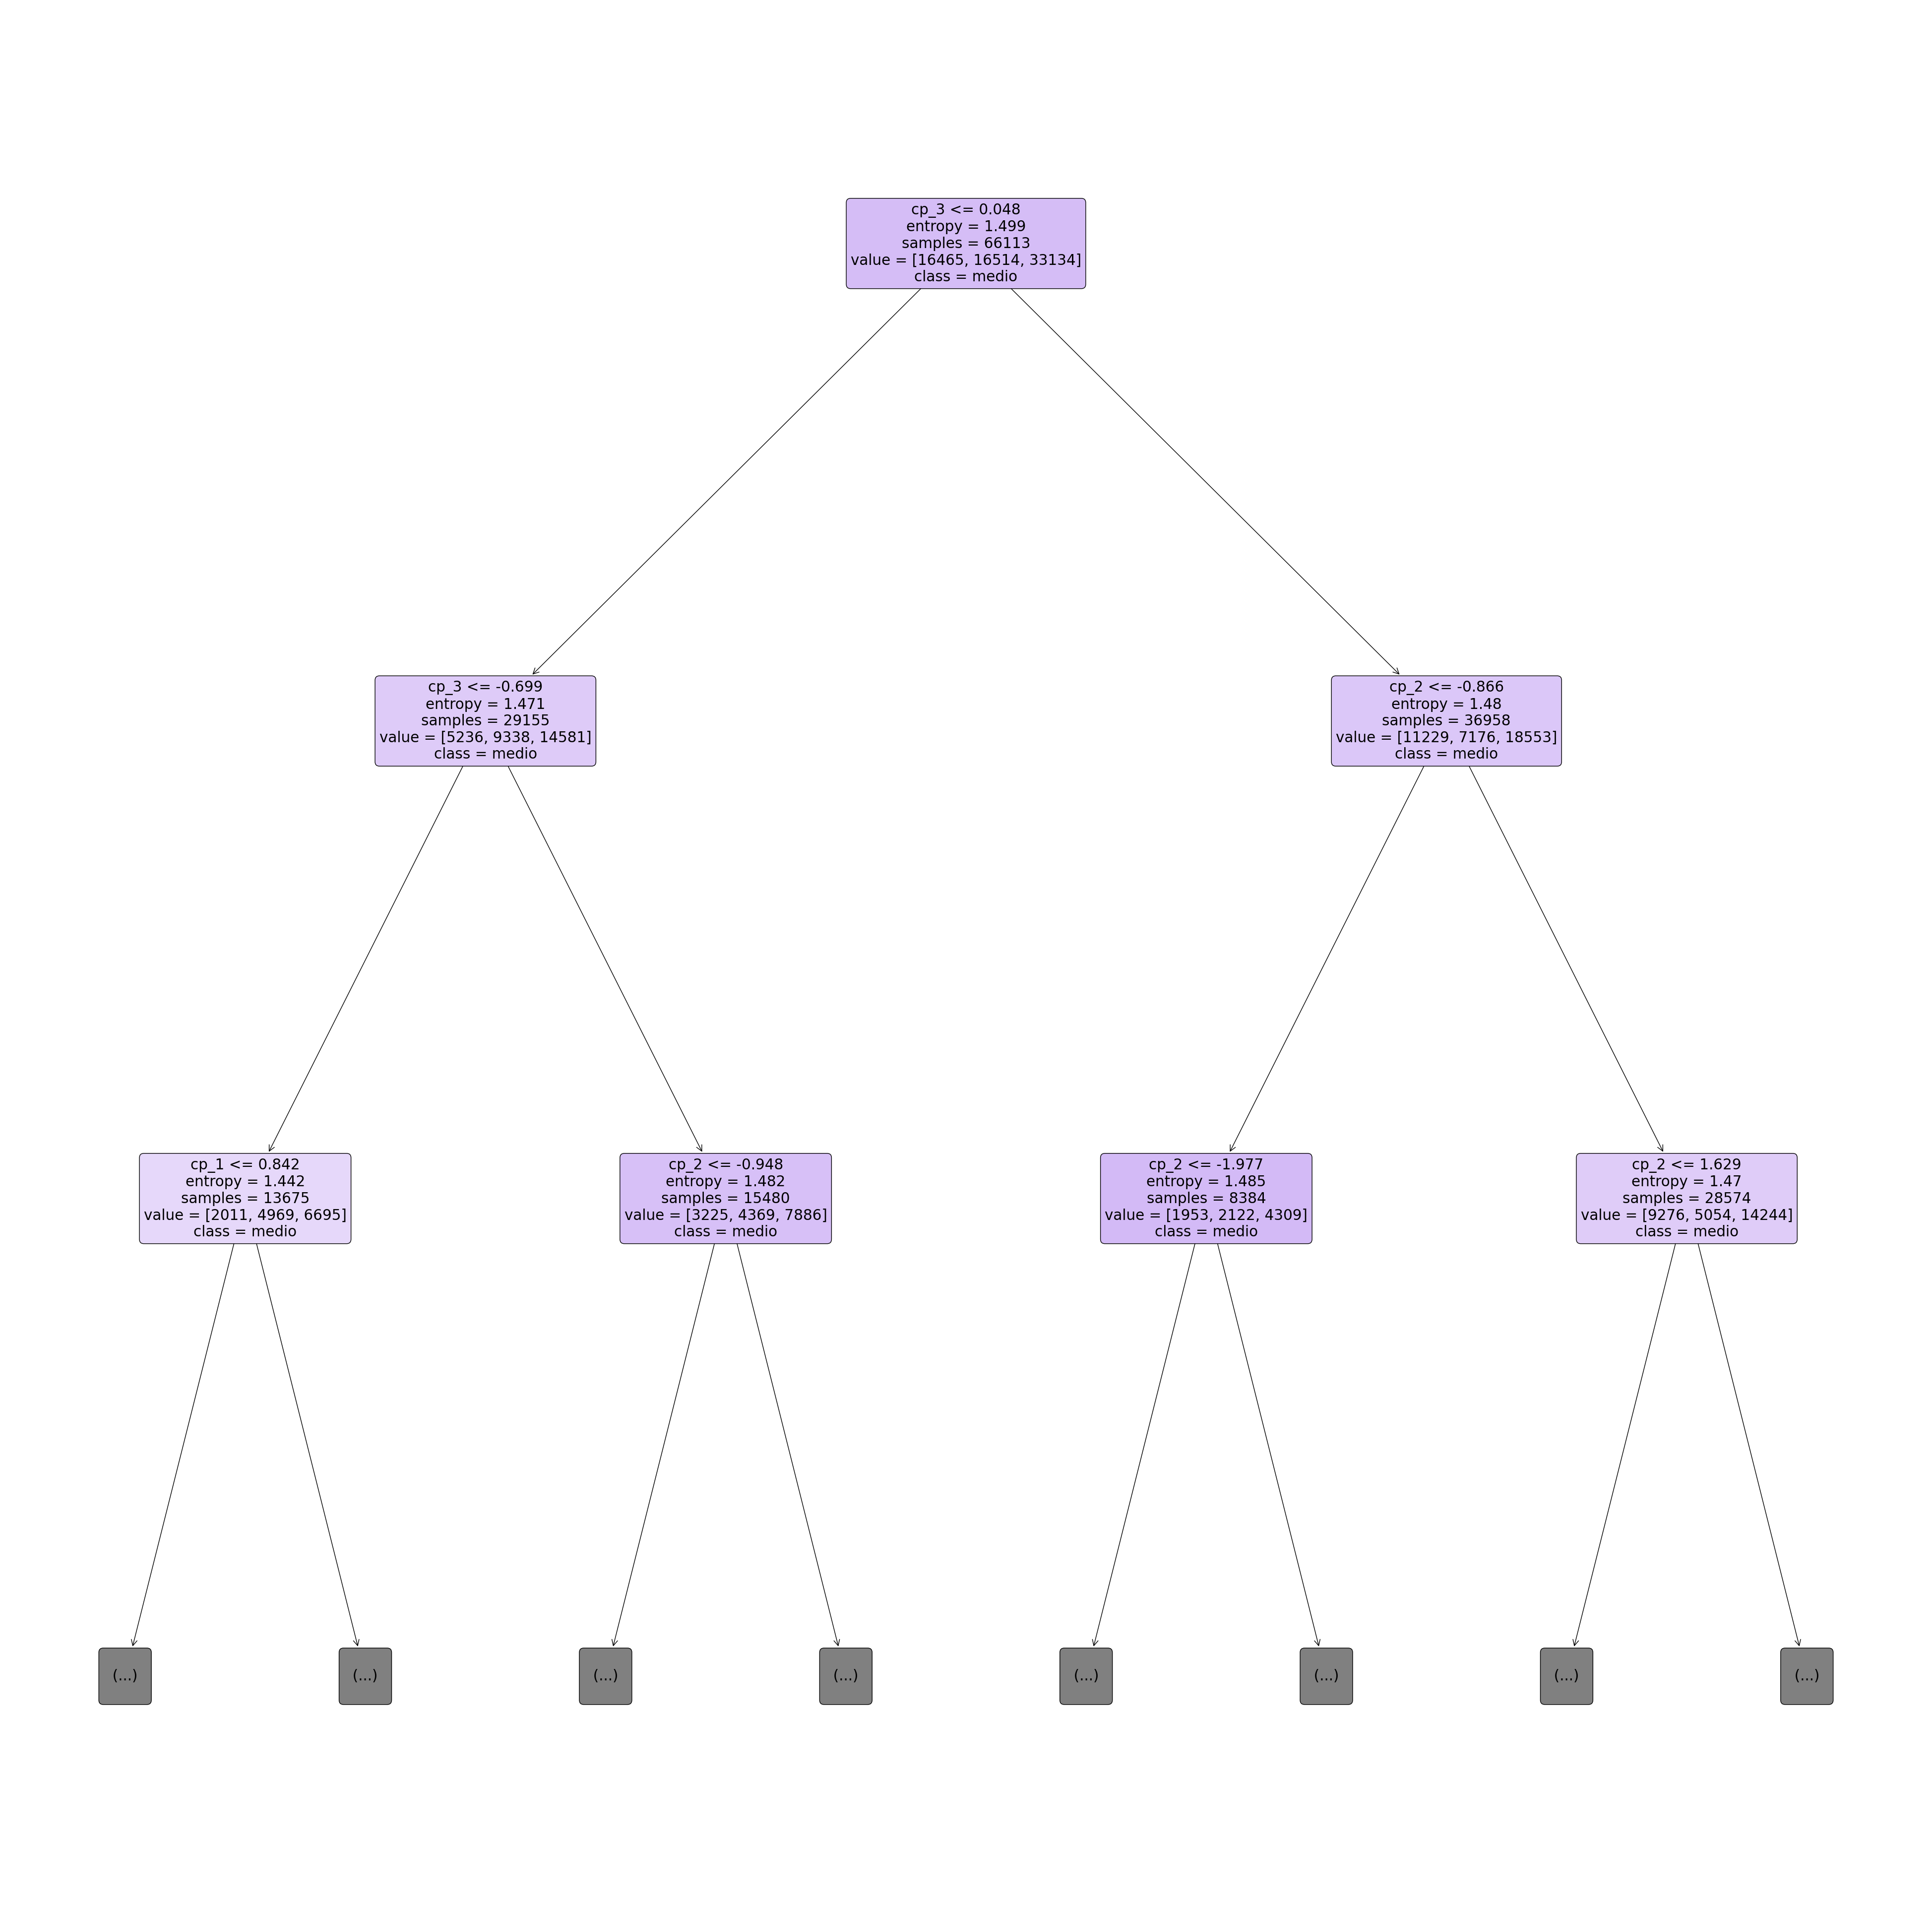

In [71]:
plt.figure(figsize=(50,50))

tree_plot=tree.plot_tree(arbolcv,
                        feature_names=x_train.columns.to_list(),
                        filled=True,
                        rounded=True,
                        max_depth=2,
                        class_names=['alto', 'bajo', 'medio'])
plt.show(tree_plot)

#### Analisis del árbol de decisión

In [72]:
reglas = export_text(arbolcv, feature_names=list(df_dTree_x))
print(reglas)

|--- cp_3 <= 0.05
|   |--- cp_3 <= -0.70
|   |   |--- cp_1 <= 0.84
|   |   |   |--- cp_4 <= 0.98
|   |   |   |   |--- cp_3 <= -2.03
|   |   |   |   |   |--- class: medio
|   |   |   |   |--- cp_3 >  -2.03
|   |   |   |   |   |--- class: medio
|   |   |   |--- cp_4 >  0.98
|   |   |   |   |--- cp_1 <= -0.81
|   |   |   |   |   |--- class: medio
|   |   |   |   |--- cp_1 >  -0.81
|   |   |   |   |   |--- class: medio
|   |   |--- cp_1 >  0.84
|   |   |   |--- cp_3 <= -1.12
|   |   |   |   |--- cp_2 <= 1.80
|   |   |   |   |   |--- class: bajo
|   |   |   |   |--- cp_2 >  1.80
|   |   |   |   |   |--- class: alto
|   |   |   |--- cp_3 >  -1.12
|   |   |   |   |--- cp_4 <= 0.38
|   |   |   |   |   |--- class: medio
|   |   |   |   |--- cp_4 >  0.38
|   |   |   |   |   |--- class: medio
|   |--- cp_3 >  -0.70
|   |   |--- cp_2 <= -0.95
|   |   |   |--- cp_4 <= -0.24
|   |   |   |   |--- cp_2 <= -2.23
|   |   |   |   |   |--- class: medio
|   |   |   |   |--- cp_2 >  -2.23
|   |   |   |   | 

EXPLICAR REGLAS DEL ARBOL

#### Evaluación de la performance del árbol de decisión

Entrenamos al modelo y vemos valores predichos

In [73]:
arbolcv_entrenado = arbolcv.fit(X = x_train, y = y_train)
y_pred = arbolcv.predict(x_test)
y_pred

array(['medio', 'medio', 'medio', ..., 'medio', 'medio', 'medio'],
      dtype=object)

In [74]:
y_test.values

['alto', 'bajo', 'medio', 'medio', 'medio', ..., 'alto', 'bajo', 'medio', 'medio', 'bajo']
Length: 16529
Categories (3, object): ['bajo' < 'medio' < 'alto']

Evaluación performance en el conjunto de evaluación.

In [75]:
y_pred = arbolcv.predict(x_test)
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred,average="weighted")
f1=f1_score(y_test,y_pred,average="weighted")

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

Accuracy: 0.5002117490471293
Recall: 0.5002117490471293
f1 score: 0.3659457395712317


In [76]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        alto       0.00      0.00      0.00      4095
        bajo       0.45      0.09      0.14      4177
       medio       0.50      0.96      0.66      8257

    accuracy                           0.50     16529
   macro avg       0.32      0.35      0.27     16529
weighted avg       0.37      0.50      0.37     16529



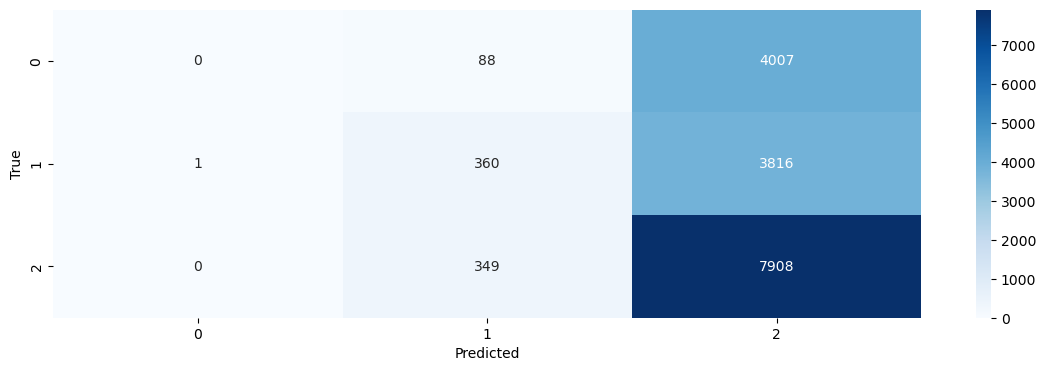

In [77]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred, labels=np.unique(y_test))
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

AGREGAR EXPLICACIÓN DE LA MATRIZ

## Modelo 2 - Random forest

### Metricas

- **RMSE:**

Agregar metricas

### Ajuste del dataset

In [78]:
df_randomF = df_EyP.copy()
df_randomF = pd.get_dummies(df_randomF, columns=["place_l3","property_type"], drop_first=True)
df_randomF['tipo_precio'] = pd.factorize(df_randomF.tipo_precio)[0]
df_randomF.head()

latitud   longitud  property_rooms  property_bedrooms  \
0 -34.589974 -58.459133               4                  3   
1 -34.637319 -58.361124               3                  2   
2 -34.628647 -58.361871               4                  3   
3 -34.610027 -58.401934               4                  2   
4 -34.631621 -58.416825               4                  2   

   property_surface_total  property_surface_covered  tipo_precio  \
0              171.000000                     133.0            0   
1               58.000000                      55.0            0   
2               70.000000                      70.0            0   
3              135.327513                     104.0            0   
4              106.415511                      73.0            1   

   place_l3_Agronomía  place_l3_Almagro  place_l3_Balvanera  ...  \
0                   0                 0                   0  ...   
1                   0                 0                   0  ...   
2                   0                 0                   0  ...   
3                   0                 0                   0  ...   
4                   0                 0                   0  ...   

   place_l3_Villa Ortuzar  place_l3_Villa Pueyrredón  place_l3_Villa Real  \
0                       0                          0                    0   
1                       0                          0                    0   
2                       0                          0                    0   
3                       0                          0                    0   
4                       0                          0                    0   

   place_l3_Villa Riachuelo  place_l3_Villa Santa Rita  \
0                         0                          0   
1                         0                          0   
2                         0                          0   
3                         0                          0   
4                         0                          0   

   place_l3_Villa Soldati  place_l3_Villa Urquiza  place_l3_Villa del Parque  \
0                       0                       0                          0   
1                       0                       0                          0   
2                       0                       0                          0   
3                       0                       0                          0   
4                       0                       0                          0   

   property_type_Departamento  property_type_PH  
0                           0                 0  
1                           1                 0  
2                           1                 0  
3                           1                 0  
4                           0                 1  

[5 rows x 65 columns]

In [79]:
df_randomF_x = df_randomF.drop(columns = "tipo_precio")
df_randomF_y = df_randomF['tipo_precio']

#Generamos los conjuntos de train y test
x_train, x_test, y_train, y_test = train_test_split(
                                        df_randomF_x, 
                                        df_randomF_y, 
                                        test_size=0.2,  #proporcion 80/20
                                        random_state=42
                                    )

### Prueba con el modelo sin optimización

In [80]:
random_forest = RandomForestClassifier(random_state=42)

random_forest.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [81]:
'''scores = cross_val_score(
                    random_forest,
                    df_randomF_x,
                    df_randomF_y,
                    scoring="neg_mean_squared_error",
                    cv=10,
                    n_jobs=-1
                )

rmse = np.sqrt(-scores)
print("Valores RMSE: ", np.round(rmse, 2))
print("Promedio RMSE: ", np.mean(rmse))'''


'scores = cross_val_score(\n                    random_forest,\n                    df_randomF_x,\n                    df_randomF_y,\n                    scoring="neg_mean_squared_error",\n                    cv=10,\n                    n_jobs=-1\n                )\n\nrmse = np.sqrt(-scores)\nprint("Valores RMSE: ", np.round(rmse, 2))\nprint("Promedio RMSE: ", np.mean(rmse))'

In [82]:
# Error test del modelo inicial
y_pred = random_forest.predict(X = x_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

print(f"El error RMSE de test es: {rmse}")

El error RMSE de test es: 0.549492103130381


In [83]:
y_pred

array([2, 0, 1, ..., 0, 1, 2])

In [84]:
y_test.values

array([2, 0, 1, ..., 0, 1, 2])

In [85]:
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred,average="weighted")
f1=f1_score(y_test,y_pred,average="weighted")

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

Accuracy: 0.7225548902195609
Recall: 0.7225548902195609
f1 score: 0.7213814143414987


In [86]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.69      0.72      4116
           1       0.71      0.78      0.74      8288
           2       0.72      0.64      0.68      4129

    accuracy                           0.72     16533
   macro avg       0.73      0.70      0.71     16533
weighted avg       0.72      0.72      0.72     16533



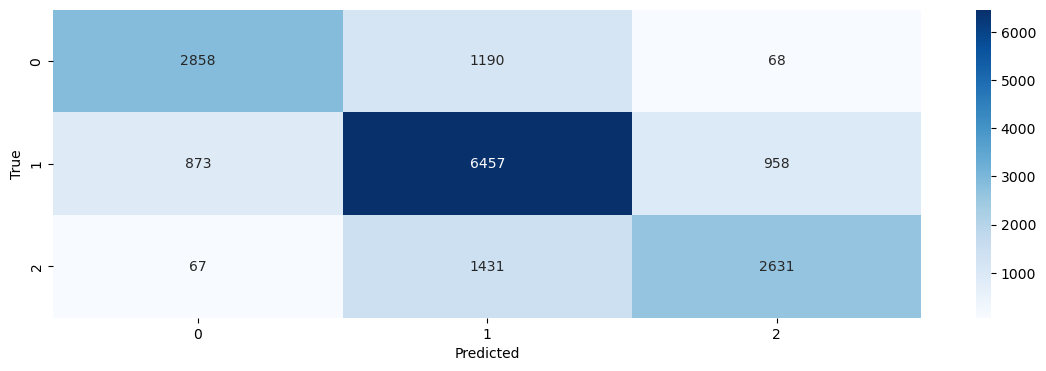

In [87]:
#Matriz de Confusión

cm = confusion_matrix(y_test,y_pred, labels=np.unique(y_test))
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Notamos que a diferencia del árbol de decisión, el random forest tiende a clasificar a las propiedades como precio bajo.

### Optimizamos los hiperparámetros

In [88]:
param_dist = {
            'max_depth': list(range(1,16)),
            #'min_samples_leaf': [5,10,20,50,100,200],
            #'n_estimators': [10,25,30,50,100,200],
            #'max_features': ['sqrt', 'log2'],
            'criterion': ['gini', 'entropy']
        }

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=5) # 5 folds para cross validation

grid_search = GridSearchCV(
                random_forest,
                param_grid=param_dist, 
                cv = kfoldcv, 
                n_jobs = -1
            )

grid_search.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15]})

In [89]:
#Mejores hiperparametros del arbol
print(grid_search.best_params_)
#Mejor métrica
print(grid_search.best_score_)

{'criterion': 'entropy', 'max_depth': 15}
0.6760623015272947


Atributos considerados y su importancia

In [90]:
best_tree = grid_search.best_estimator_
feat_imps = best_tree.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,df_randomF.columns)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

place_l3_Floresta: 1.7692034349366043e-05
place_l3_Caballito: 2.1335393169619086e-05
place_l3_Villa Real: 4.02685101384949e-05
place_l3_Catalinas: 7.179020664856825e-05
place_l3_Villa Pueyrredón: 8.082127627786803e-05
place_l3_San Telmo: 8.677384835955869e-05
place_l3_Villa Santa Rita: 9.877385902095024e-05
place_l3_Parque Avellaneda: 0.00012760434287010063
place_l3_Tribunales: 0.00015803452363706116
place_l3_Villa Riachuelo: 0.00018907322316527318
place_l3_Velez Sarsfield: 0.00022968390307345434
place_l3_Monserrat: 0.0002733701806730514
tipo_precio: 0.00032748238958130816
place_l3_Villa Devoto: 0.0003345890245921399
place_l3_Parque Chacabuco: 0.0003797011829190712
place_l3_Villa Lugano: 0.0004162941749958917
place_l3_Las Cañitas: 0.0004928599299498639
place_l3_Parque Chas: 0.0006045805195288591
place_l3_Parque Centenario: 0.0006274346296925812
place_l3_Centro / Microcentro: 0.00066550632666967
place_l3_Paternal: 0.0007033220662315607
place_l3_Parque Patricios: 0.0008386572646341005
pl

Nuestro atributo de mayor importancia es...

### Construcción del árbol con mejores parametros

In [91]:
random_forest = RandomForestClassifier(random_state=42).set_params(**grid_search.best_params_)

random_forest.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=15, random_state=42)

#### Grafico del árbol

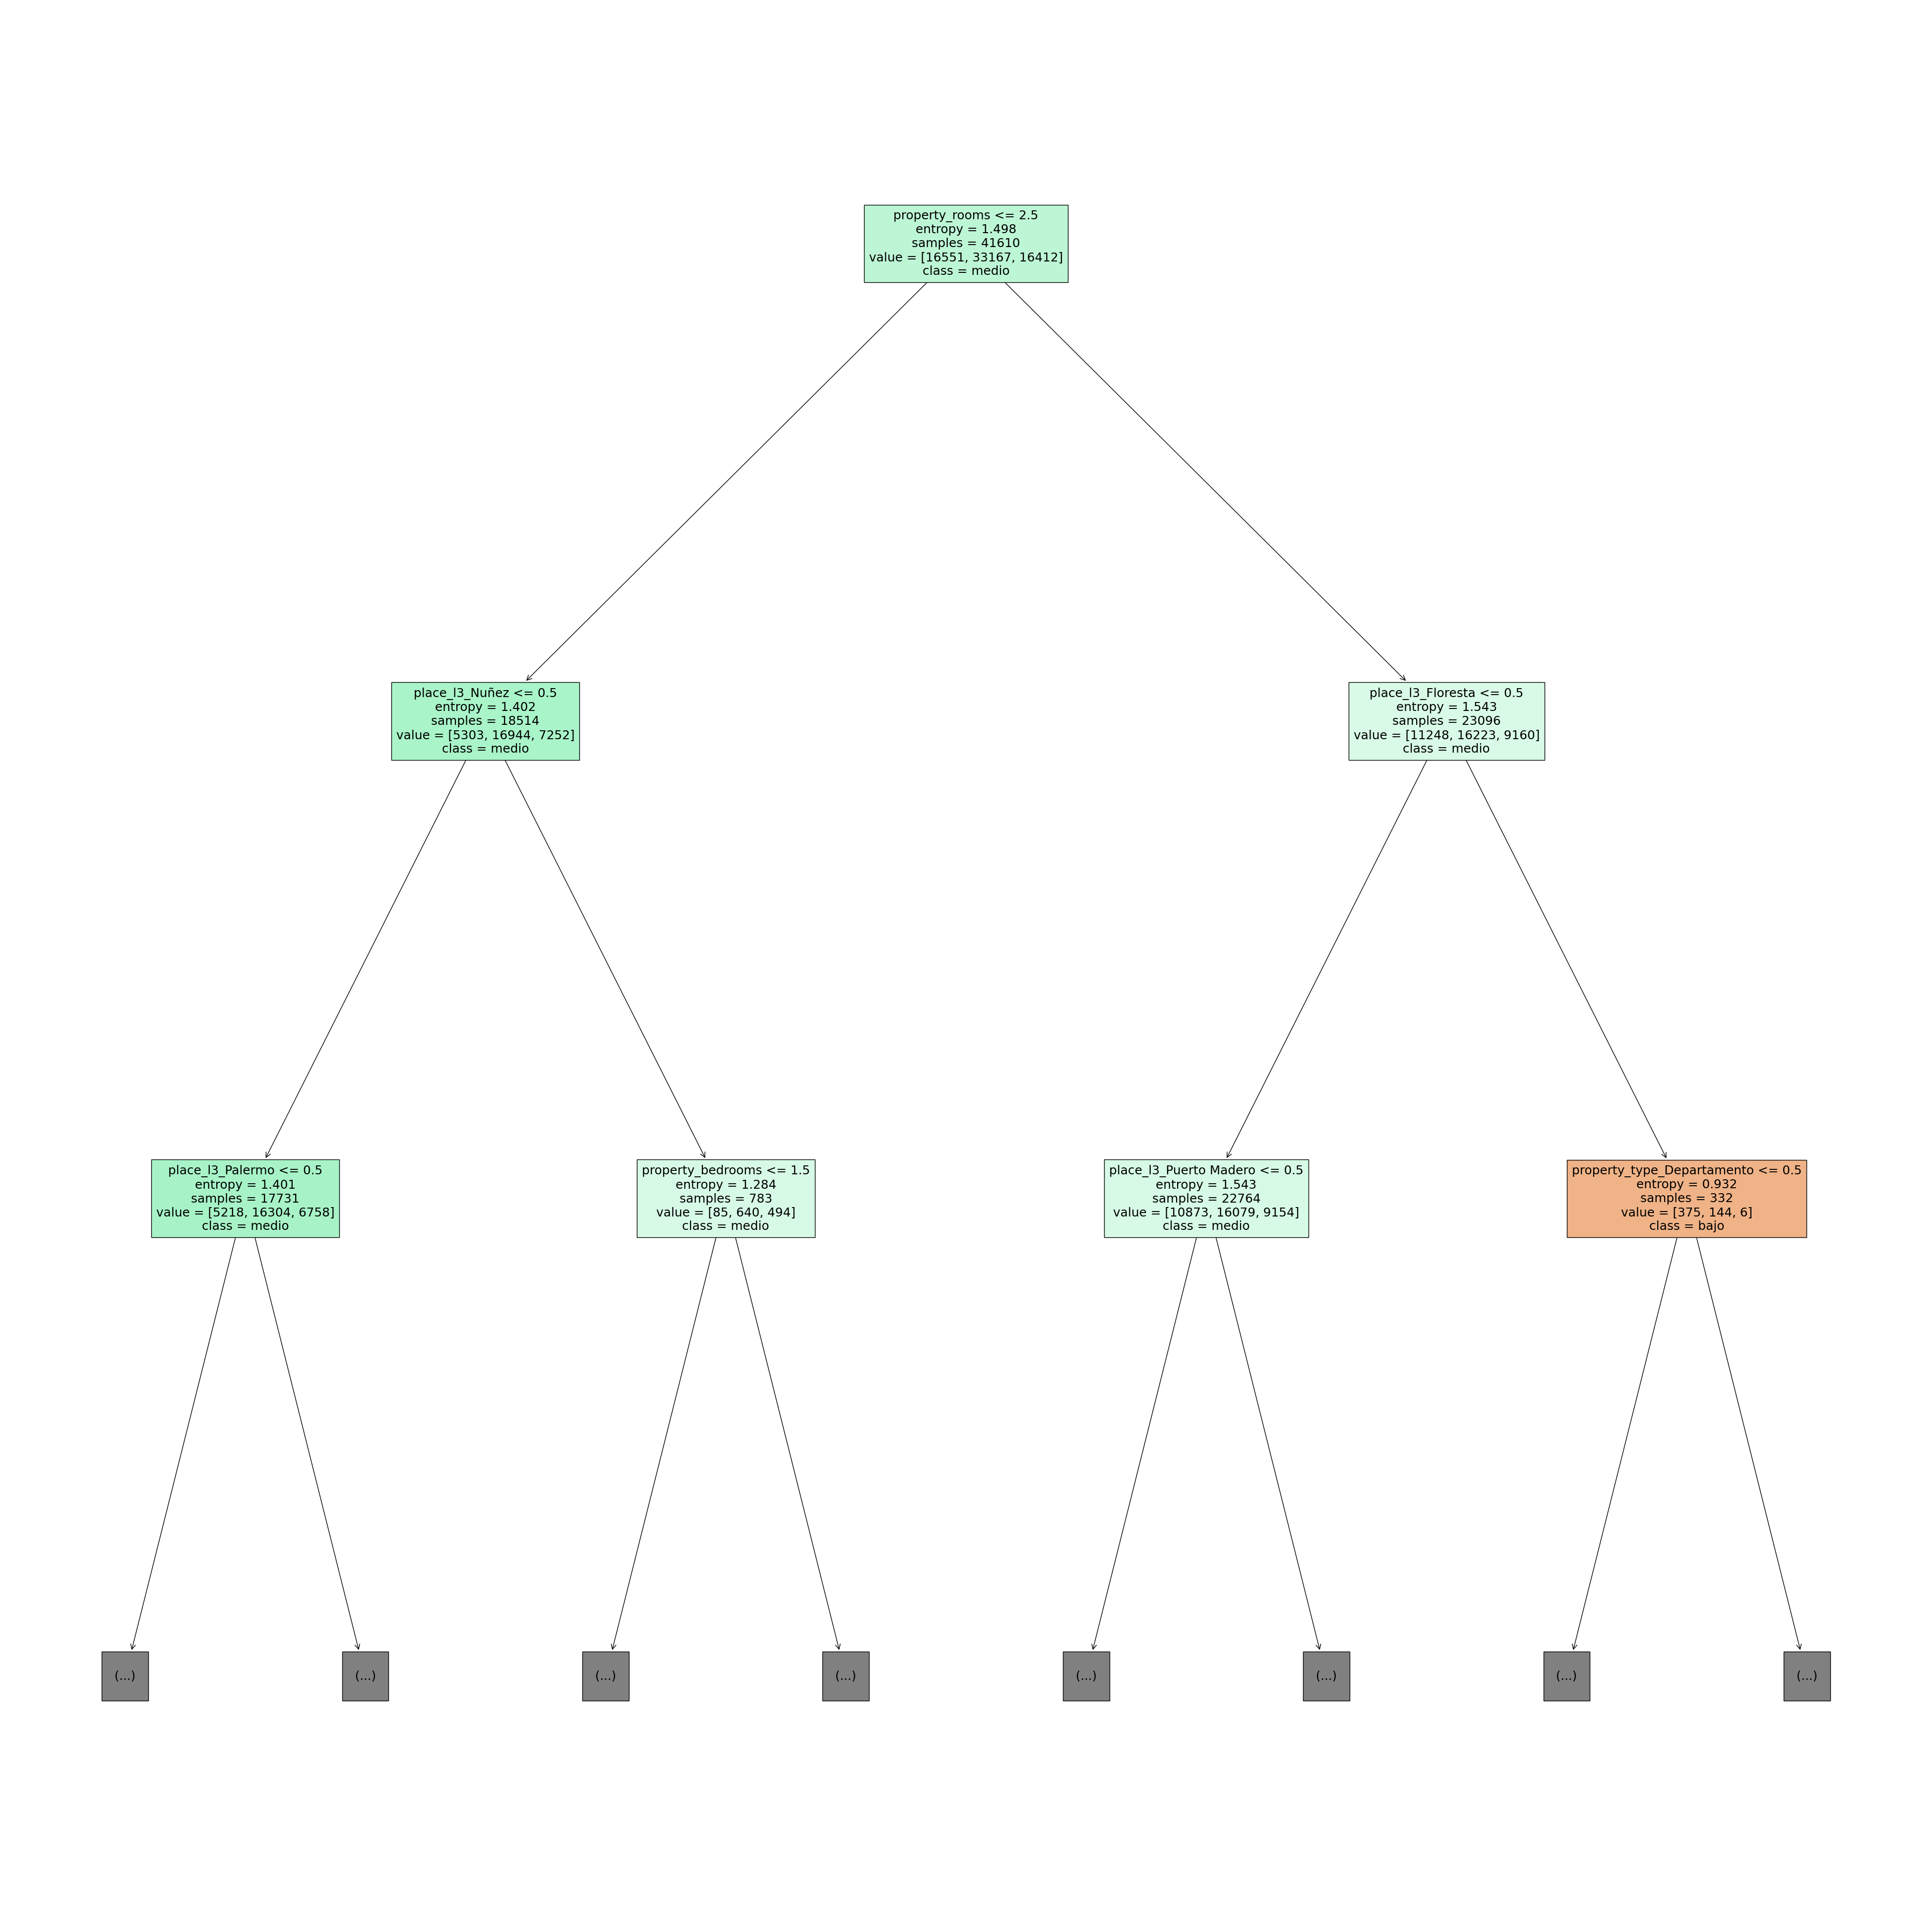

In [92]:
plt.figure(figsize=(50,50))

'''tree_plot=tree.plot_tree(random_forest,
                        feature_names=x_train.columns.to_list(),
                        filled=True,
                        rounded=True,
                        max_depth=2,
                        class_names=['alto', 'bajo', 'medio'])'''

tree_plot=tree.plot_tree(grid_search.best_estimator_[5], 
                         feature_names = df_randomF_x.columns,
                         filled=True,
                         max_depth=2,
                         class_names=['bajo', 'medio', 'alto'])

plt.show(tree_plot)

#### Analisis del árbol de decisión

In [93]:
reglas = export_text(arbolcv, feature_names=list(df_dTree_x))
print(reglas)

|--- cp_3 <= 0.05
|   |--- cp_3 <= -0.70
|   |   |--- cp_1 <= 0.84
|   |   |   |--- cp_4 <= 0.98
|   |   |   |   |--- cp_3 <= -2.03
|   |   |   |   |   |--- class: medio
|   |   |   |   |--- cp_3 >  -2.03
|   |   |   |   |   |--- class: medio
|   |   |   |--- cp_4 >  0.98
|   |   |   |   |--- cp_1 <= -0.81
|   |   |   |   |   |--- class: medio
|   |   |   |   |--- cp_1 >  -0.81
|   |   |   |   |   |--- class: medio
|   |   |--- cp_1 >  0.84
|   |   |   |--- cp_3 <= -1.12
|   |   |   |   |--- cp_2 <= 1.80
|   |   |   |   |   |--- class: bajo
|   |   |   |   |--- cp_2 >  1.80
|   |   |   |   |   |--- class: alto
|   |   |   |--- cp_3 >  -1.12
|   |   |   |   |--- cp_4 <= 0.38
|   |   |   |   |   |--- class: medio
|   |   |   |   |--- cp_4 >  0.38
|   |   |   |   |   |--- class: medio
|   |--- cp_3 >  -0.70
|   |   |--- cp_2 <= -0.95
|   |   |   |--- cp_4 <= -0.24
|   |   |   |   |--- cp_2 <= -2.23
|   |   |   |   |   |--- class: medio
|   |   |   |   |--- cp_2 >  -2.23
|   |   |   |   | 

EXPLICAR REGLAS DEL ARBOL

### Evaluación de la performance del árbol en el conjunto de evaluación

In [94]:
random_forest.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=15, random_state=42)

Error luego de setear los hiperparámetros

In [95]:
'''scores = cross_val_score(
                    random_forest,
                    df_randomF_x,
                    df_randomF_y,
                    scoring="neg_mean_squared_error",
                    cv=10,
                    n_jobs=-1
                )

rmse = np.sqrt(-scores)
print("Valores RMSE: ", np.round(rmse, 2))
print("Promedio RMSE: ", np.mean(rmse))'''

'scores = cross_val_score(\n                    random_forest,\n                    df_randomF_x,\n                    df_randomF_y,\n                    scoring="neg_mean_squared_error",\n                    cv=10,\n                    n_jobs=-1\n                )\n\nrmse = np.sqrt(-scores)\nprint("Valores RMSE: ", np.round(rmse, 2))\nprint("Promedio RMSE: ", np.mean(rmse))'

In [96]:
y_pred = random_forest.predict(X = x_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

print(f"El error RMSE de test es: {rmse}")

El error RMSE de test es: 0.5831356432002177


In [97]:
y_pred

array([2, 0, 1, ..., 0, 1, 2])

In [98]:
y_test.values

array([2, 0, 1, ..., 0, 1, 2])

In [99]:
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred,average="weighted")
f1=f1_score(y_test,y_pred,average="weighted")

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

Accuracy: 0.6761023407729995
Recall: 0.6761023407729995
f1 score: 0.6657865718027928


In [100]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.56      0.65      4116
           1       0.64      0.84      0.73      8288
           2       0.72      0.46      0.56      4129

    accuracy                           0.68     16533
   macro avg       0.71      0.62      0.65     16533
weighted avg       0.69      0.68      0.67     16533



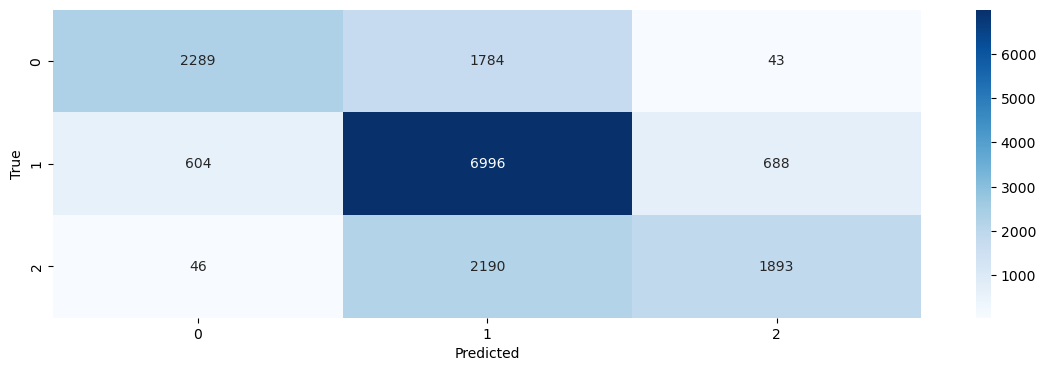

In [101]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred, labels=np.unique(y_test))
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Entrenamiento con PCA

#### Ajuste del dataset

In [102]:
df_randomF_pca=pd.read_csv('./data/properati_argentina_2021_pca.csv')

df_randomF_pca["tipo_precio"] = df_EyP["tipo_precio"]
df_randomF_pca.drop("Unnamed: 0",axis=1, inplace=True)

df_randomF_pca.dropna(inplace=True)

In [103]:
df_randomF_pca_x = df_randomF_pca.drop(columns = "tipo_precio")
df_randomF_pca_y = df_randomF_pca['tipo_precio']

#Generamos los conjuntos de train y test
x_train, x_test, y_train, y_test = train_test_split(
                                        df_randomF_pca_x, 
                                        df_randomF_pca_y, 
                                        test_size=0.2,  #proporcion 80/20
                                        random_state=42
                                    )

#### Prueba con el modelo sin optimización

In [104]:
random_forest_pca = RandomForestClassifier(random_state=42)
random_forest_pca.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [105]:
'''scores = cross_val_score(
                    random_forest,
                    df_randomF_x,
                    df_randomF_y,
                    scoring="neg_mean_squared_error",
                    cv=10,
                    n_jobs=-1
                )

rmse = np.sqrt(-scores)
print("Valores RMSE: ", np.round(rmse, 2))
print("Promedio RMSE: ", np.mean(rmse))'''

'scores = cross_val_score(\n                    random_forest,\n                    df_randomF_x,\n                    df_randomF_y,\n                    scoring="neg_mean_squared_error",\n                    cv=10,\n                    n_jobs=-1\n                )\n\nrmse = np.sqrt(-scores)\nprint("Valores RMSE: ", np.round(rmse, 2))\nprint("Promedio RMSE: ", np.mean(rmse))'

In [106]:
y_pred = random_forest_pca.predict(X = x_test)

'''rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

print(f"El error RMSE de test es: {rmse}")'''

'rmse = mean_squared_error(\n        y_true  = y_test,\n        y_pred  = y_pred,\n        squared = False\n       )\n\nprint(f"El error RMSE de test es: {rmse}")'

In [107]:
y_pred

array(['alto', 'medio', 'alto', ..., 'medio', 'medio', 'medio'],
      dtype=object)

In [108]:
y_test.values

['alto', 'medio', 'alto', 'bajo', 'bajo', ..., 'medio', 'alto', 'alto', 'medio', 'alto']
Length: 16529
Categories (3, object): ['bajo' < 'medio' < 'alto']

In [109]:
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred,average="weighted")
f1=f1_score(y_test,y_pred,average="weighted")

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

Accuracy: 0.4521144654849053
Recall: 0.4521144654849053
f1 score: 0.4307471662959575


In [110]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        alto       0.34      0.24      0.28      4112
        bajo       0.35      0.24      0.29      4126
       medio       0.51      0.66      0.58      8291

    accuracy                           0.45     16529
   macro avg       0.40      0.38      0.38     16529
weighted avg       0.43      0.45      0.43     16529



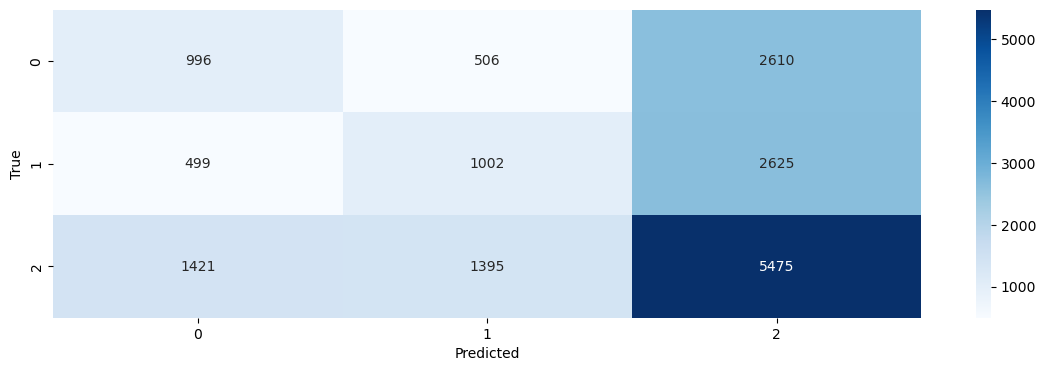

In [111]:
cm = confusion_matrix(y_test,y_pred, labels=np.unique(y_test))
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

EXPLICAR MATRIZ DE CONFUSIÓN

#### Optimización de hiperparametros

In [112]:
param_dist = {
            'max_depth': list(range(1,16)),
            #'min_samples_leaf': [5,10,20,50,100,200],
            #'n_estimators': [10,25,30,50,100,200],
            #'max_features': ['sqrt', 'log2'],
            'criterion': ['gini', 'entropy']
        }

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=5) # 5 folds para cross validation

grid_search = GridSearchCV(
                random_forest_pca,
                param_grid=param_dist,
                cv = kfoldcv, 
                n_jobs = -1
            )

grid_search.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15]})

In [113]:
#Mejores hiperparametros del arbol
print(grid_search.best_params_)
#Mejor métrica
print(grid_search.best_score_)

{'criterion': 'entropy', 'max_depth': 7}
0.5016411302697878


Atributos considerados y su importancia

In [114]:
best_tree = grid_search.best_estimator_
feat_imps = best_tree.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,df_randomF_pca.columns)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

cp_4: 0.12337536044460017
cp_1: 0.12341300024207788
cp_2: 0.27450708393514445
cp_3: 0.4787045553781775


Nuestro atributo de mayor importancia es...

#### Construcción del árbol con mejores parametros

In [115]:
random_forest_pca = RandomForestClassifier(random_state=42).set_params(**grid_search.best_params_)

random_forest_pca.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=7, random_state=42)

#### Grafico del árbol

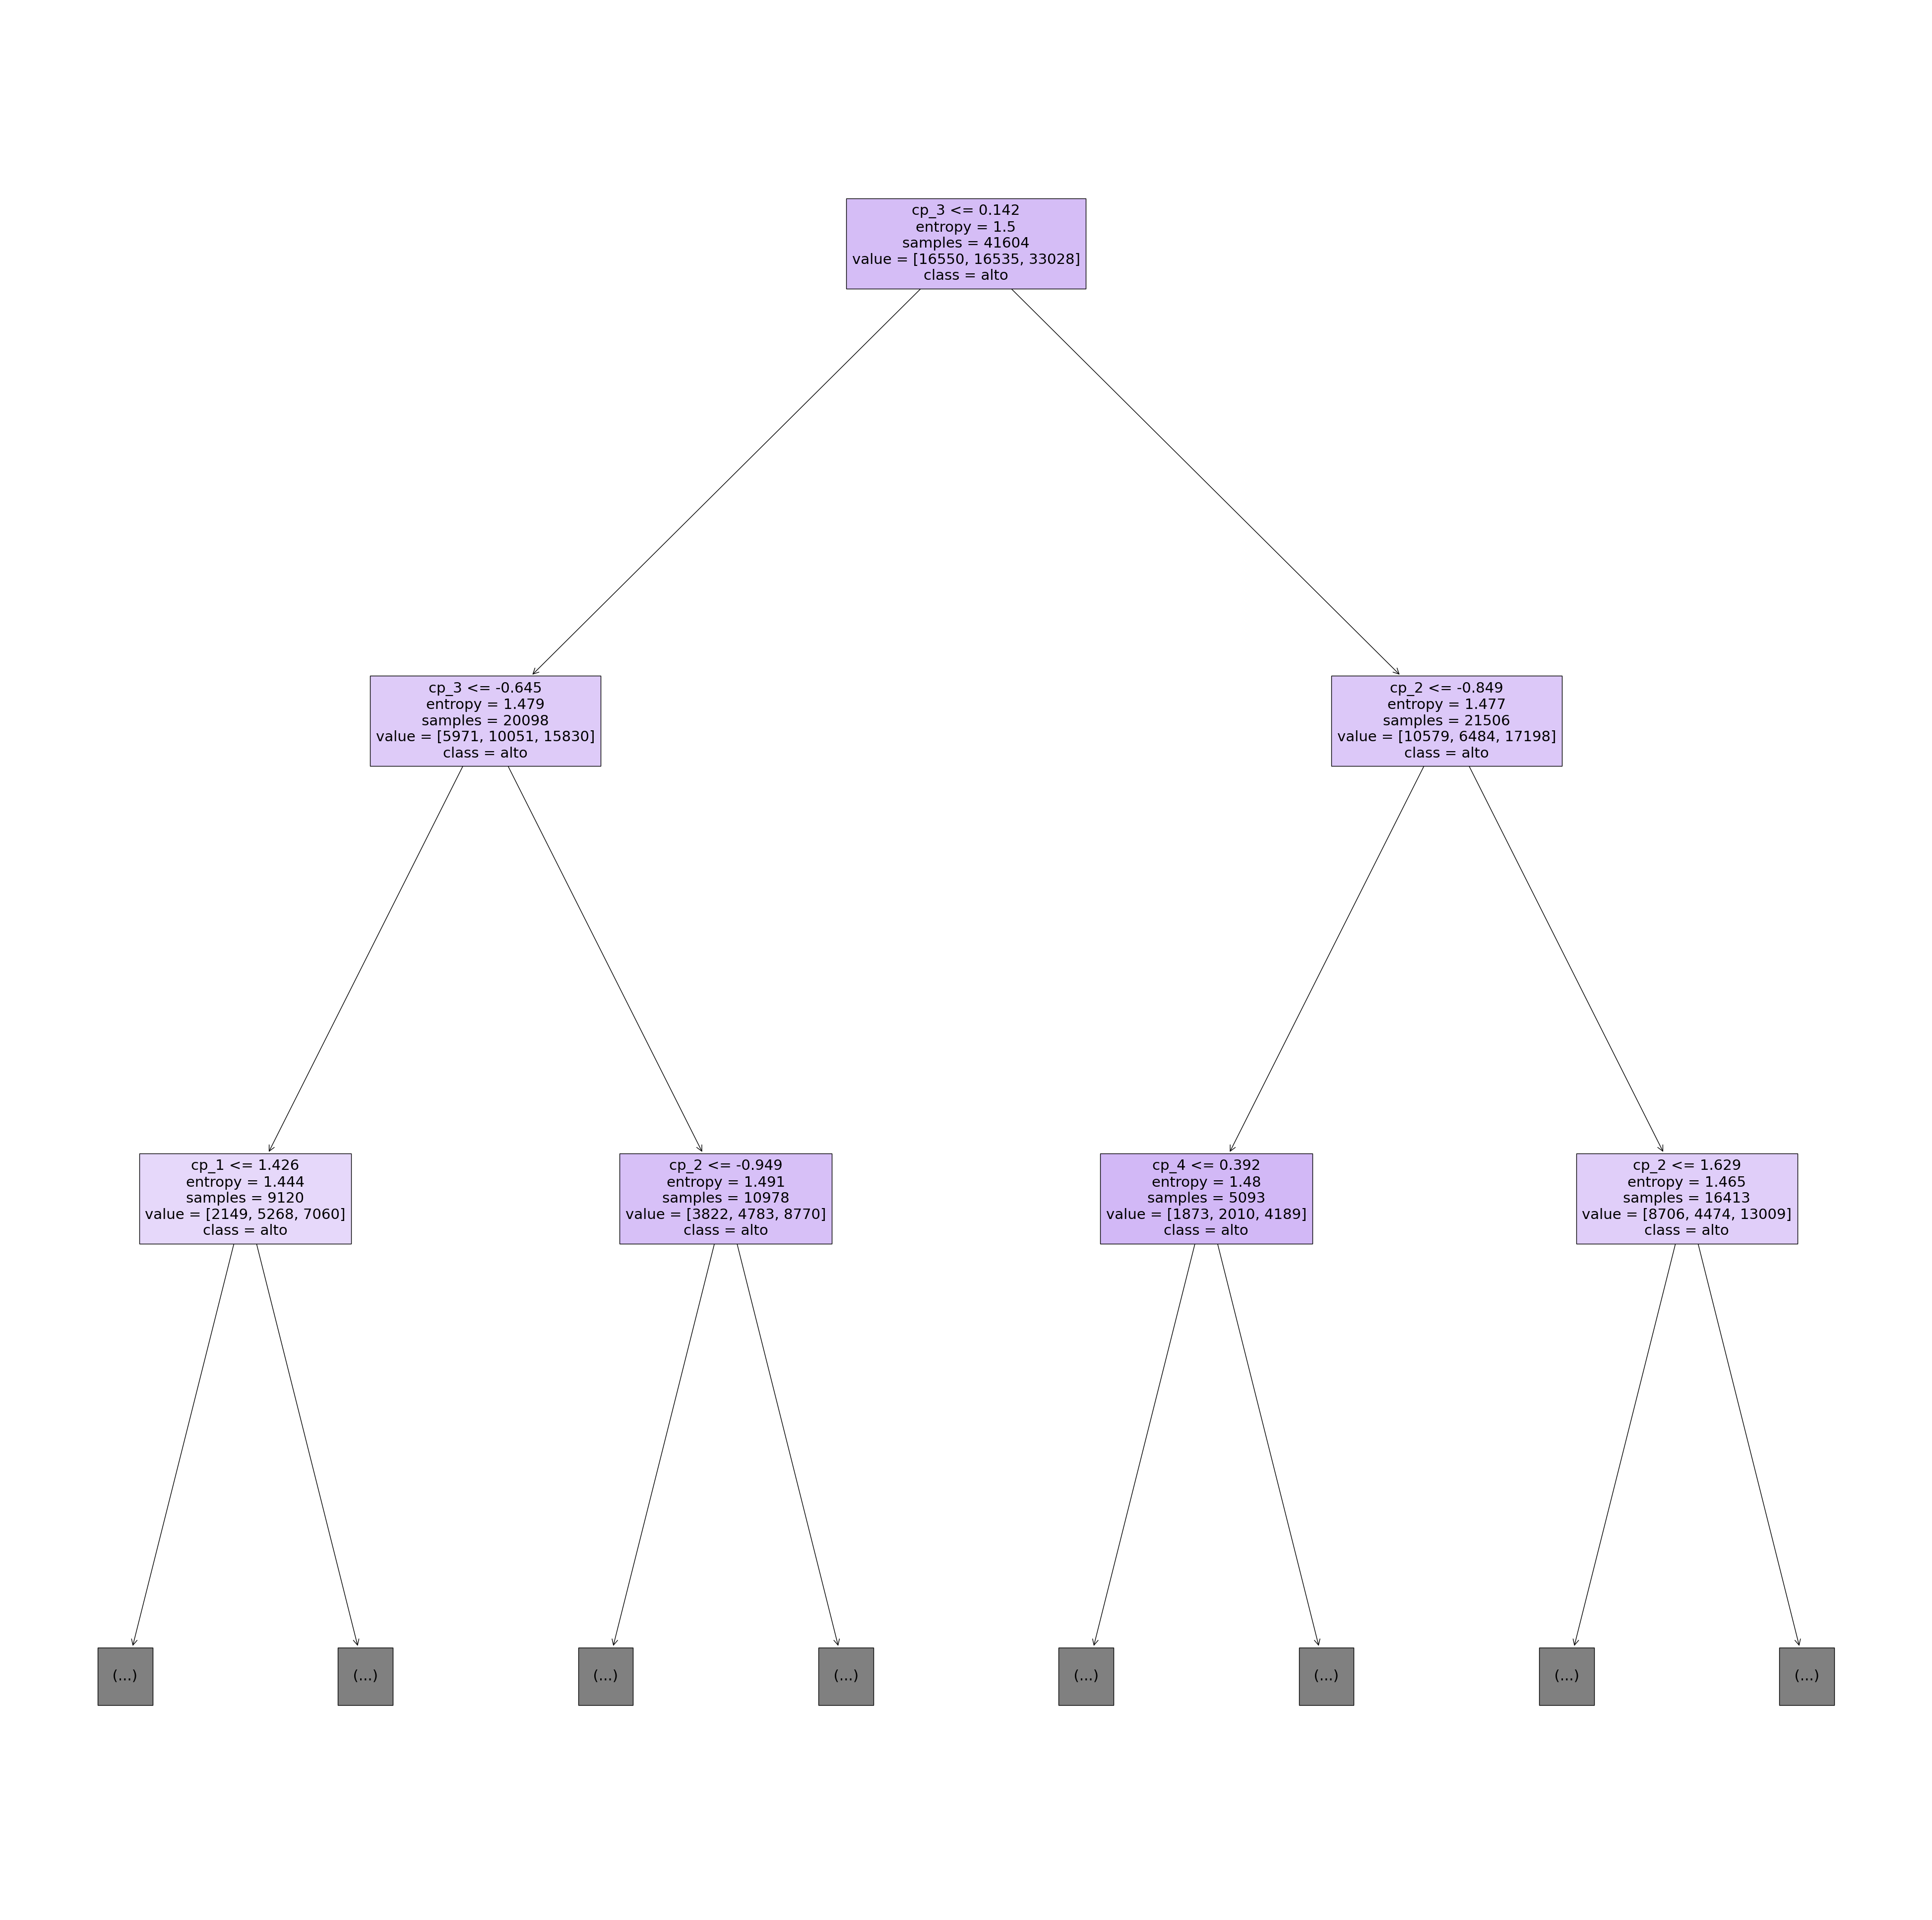

In [116]:

plt.figure(figsize=(50,50))

'''tree_plot=tree.plot_tree(random_forest,
                        feature_names=x_train.columns.to_list(),
                        filled=True,
                        rounded=True,
                        max_depth=2,
                        class_names=['alto', 'bajo', 'medio'])'''

tree_plot=tree.plot_tree(grid_search.best_estimator_[5], 
                         feature_names = df_randomF_pca_x.columns,
                         filled=True,
                         max_depth=2,
                         class_names=['bajo', 'medio', 'alto'])

plt.show(tree_plot)

##### Analisis del árbol de decisión

In [117]:
reglas = export_text(arbolcv, feature_names=list(df_dTree_x))
print(reglas)

|--- cp_3 <= 0.05
|   |--- cp_3 <= -0.70
|   |   |--- cp_1 <= 0.84
|   |   |   |--- cp_4 <= 0.98
|   |   |   |   |--- cp_3 <= -2.03
|   |   |   |   |   |--- class: medio
|   |   |   |   |--- cp_3 >  -2.03
|   |   |   |   |   |--- class: medio
|   |   |   |--- cp_4 >  0.98
|   |   |   |   |--- cp_1 <= -0.81
|   |   |   |   |   |--- class: medio
|   |   |   |   |--- cp_1 >  -0.81
|   |   |   |   |   |--- class: medio
|   |   |--- cp_1 >  0.84
|   |   |   |--- cp_3 <= -1.12
|   |   |   |   |--- cp_2 <= 1.80
|   |   |   |   |   |--- class: bajo
|   |   |   |   |--- cp_2 >  1.80
|   |   |   |   |   |--- class: alto
|   |   |   |--- cp_3 >  -1.12
|   |   |   |   |--- cp_4 <= 0.38
|   |   |   |   |   |--- class: medio
|   |   |   |   |--- cp_4 >  0.38
|   |   |   |   |   |--- class: medio
|   |--- cp_3 >  -0.70
|   |   |--- cp_2 <= -0.95
|   |   |   |--- cp_4 <= -0.24
|   |   |   |   |--- cp_2 <= -2.23
|   |   |   |   |   |--- class: medio
|   |   |   |   |--- cp_2 >  -2.23
|   |   |   |   | 

EXPLICAR REGLAS DEL ARBOL

#### Evaluación de la performance del árbol en el conjunto de evaluación

In [118]:
random_forest_pca.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=7, random_state=42)

Error luego de setear los hiperparámetros

In [119]:
'''scores = cross_val_score(
                    random_forest,
                    df_randomF_x,
                    df_randomF_y,
                    scoring="neg_mean_squared_error",
                    cv=10,
                    n_jobs=-1
                )

rmse = np.sqrt(-scores)
print("Valores RMSE: ", np.round(rmse, 2))
print("Promedio RMSE: ", np.mean(rmse))'''

'scores = cross_val_score(\n                    random_forest,\n                    df_randomF_x,\n                    df_randomF_y,\n                    scoring="neg_mean_squared_error",\n                    cv=10,\n                    n_jobs=-1\n                )\n\nrmse = np.sqrt(-scores)\nprint("Valores RMSE: ", np.round(rmse, 2))\nprint("Promedio RMSE: ", np.mean(rmse))'

In [121]:
y_pred = random_forest_pca.predict(X = x_test)

'''rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

print(f"El error RMSE de test es: {rmse}")'''

'rmse = mean_squared_error(\n        y_true  = y_test,\n        y_pred  = y_pred,\n        squared = False\n       )\n\nprint(f"El error RMSE de test es: {rmse}")'

In [122]:
y_pred

array(['medio', 'medio', 'medio', ..., 'medio', 'medio', 'medio'],
      dtype=object)

In [123]:
y_test.values

['alto', 'medio', 'alto', 'bajo', 'bajo', ..., 'medio', 'alto', 'alto', 'medio', 'alto']
Length: 16529
Categories (3, object): ['bajo' < 'medio' < 'alto']

In [124]:
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred,average="weighted")
f1=f1_score(y_test,y_pred,average="weighted")

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

Accuracy: 0.5051727267227297
Recall: 0.5051727267227297
f1 score: 0.36176237485589235


In [125]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        alto       0.22      0.00      0.00      4112
        bajo       0.50      0.06      0.11      4126
       medio       0.51      0.98      0.67      8291

    accuracy                           0.51     16529
   macro avg       0.41      0.35      0.26     16529
weighted avg       0.43      0.51      0.36     16529



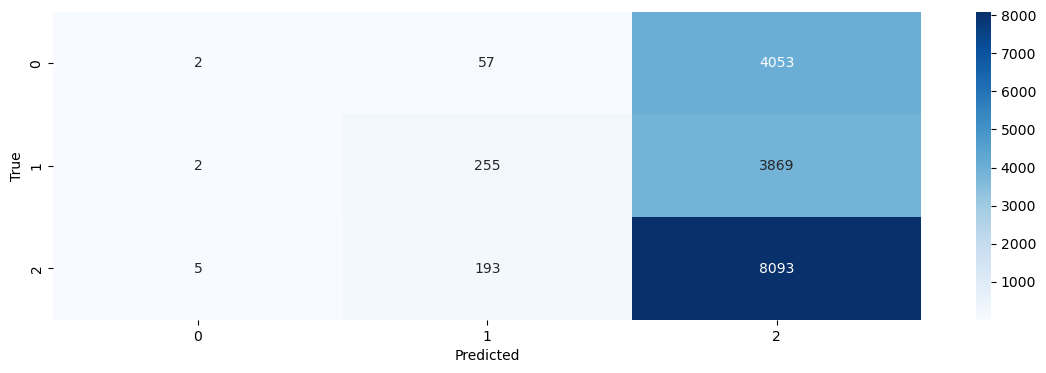

In [126]:
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Modelo 3 - KNN

In [127]:
df_KNN=df_EyP.copy()
df_KNN

latitud   longitud              place_l3 property_type  \
0     -34.589974 -58.459133               Palermo          Casa   
1     -34.637319 -58.361124                  Boca  Departamento   
2     -34.628647 -58.361871                  Boca  Departamento   
3     -34.610027 -58.401934                  Once  Departamento   
4     -34.631621 -58.416825                 Boedo            PH   
...          ...        ...                   ...           ...   
82658 -34.603245 -58.489810      Villa del Parque  Departamento   
82659 -34.614063 -58.482814      Villa del Parque  Departamento   
82660 -34.614175 -58.479062      Villa del Parque  Departamento   
82661 -34.614175 -58.479062      Villa del Parque  Departamento   
82662 -34.599790 -58.373411  Centro / Microcentro  Departamento   

       property_rooms  property_bedrooms  property_surface_total  \
0                   4                  3              171.000000   
1                   3                  2               58.000000   
2                   4                  3               70.000000   
3                   4                  2              135.327513   
4                   4                  2              106.415511   
...               ...                ...                     ...   
82658               4                  3              130.000000   
82659               3                  2               68.000000   
82660               1                  1               51.000000   
82661               1                  1               37.000000   
82662               2                  1               84.000000   

       property_surface_covered tipo_precio  
0                         133.0        bajo  
1                          55.0        bajo  
2                          70.0        bajo  
3                         104.0        bajo  
4                          73.0       medio  
...                         ...         ...  
82658                     100.0        bajo  
82659                      60.0       medio  
82660                      30.0        bajo  
82661                      31.0       medio  
82662                      84.0        bajo  

[82663 rows x 9 columns]

In [128]:
df_KNN = pd.get_dummies(df_KNN, columns=["place_l3","property_type"], drop_first=True)

In [129]:
df_KNN['tipo_precio'] = df_KNN['tipo_precio'].map({'bajo':0,'medio':1,'alto':2},na_action=None)
df_KNN['tipo_precio'].astype('int64')

0        0
1        0
2        0
3        0
4        1
        ..
82658    0
82659    1
82660    0
82661    1
82662    0
Name: tipo_precio, Length: 82663, dtype: int64

In [130]:
df_KNN.head()

latitud   longitud  property_rooms  property_bedrooms  \
0 -34.589974 -58.459133               4                  3   
1 -34.637319 -58.361124               3                  2   
2 -34.628647 -58.361871               4                  3   
3 -34.610027 -58.401934               4                  2   
4 -34.631621 -58.416825               4                  2   

   property_surface_total  property_surface_covered tipo_precio  \
0              171.000000                     133.0           0   
1               58.000000                      55.0           0   
2               70.000000                      70.0           0   
3              135.327513                     104.0           0   
4              106.415511                      73.0           1   

   place_l3_Agronomía  place_l3_Almagro  place_l3_Balvanera  ...  \
0                   0                 0                   0  ...   
1                   0                 0                   0  ...   
2                   0                 0                   0  ...   
3                   0                 0                   0  ...   
4                   0                 0                   0  ...   

   place_l3_Villa Ortuzar  place_l3_Villa Pueyrredón  place_l3_Villa Real  \
0                       0                          0                    0   
1                       0                          0                    0   
2                       0                          0                    0   
3                       0                          0                    0   
4                       0                          0                    0   

   place_l3_Villa Riachuelo  place_l3_Villa Santa Rita  \
0                         0                          0   
1                         0                          0   
2                         0                          0   
3                         0                          0   
4                         0                          0   

   place_l3_Villa Soldati  place_l3_Villa Urquiza  place_l3_Villa del Parque  \
0                       0                       0                          0   
1                       0                       0                          0   
2                       0                       0                          0   
3                       0                       0                          0   
4                       0                       0                          0   

   property_type_Departamento  property_type_PH  
0                           0                 0  
1                           1                 0  
2                           1                 0  
3                           1                 0  
4                           0                 1  

[5 rows x 65 columns]

In [131]:
# Seleccione variable para predecir
X = df_KNN.drop(["tipo_precio"], axis=1)
y = df_KNN[['tipo_precio']]

#Separacion Train/test  (80/20) según lo pedido
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=2)

In [132]:
#Creamos el modelo
knn = KNeighborsClassifier()

#Miramos los parámetros por defecto
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [133]:
# Variamos la cantidad de vecinos (K)
metrics = [] #cantidad de vecinos y cantidad de aciertos

k_range=range(1, 200,5) # vecinos desde 1 hasta 200 con intervalos de 5

for n in k_range:

    knn = KNeighborsRegressor(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    metrics.append((n, int((y_test == y_pred).sum())))

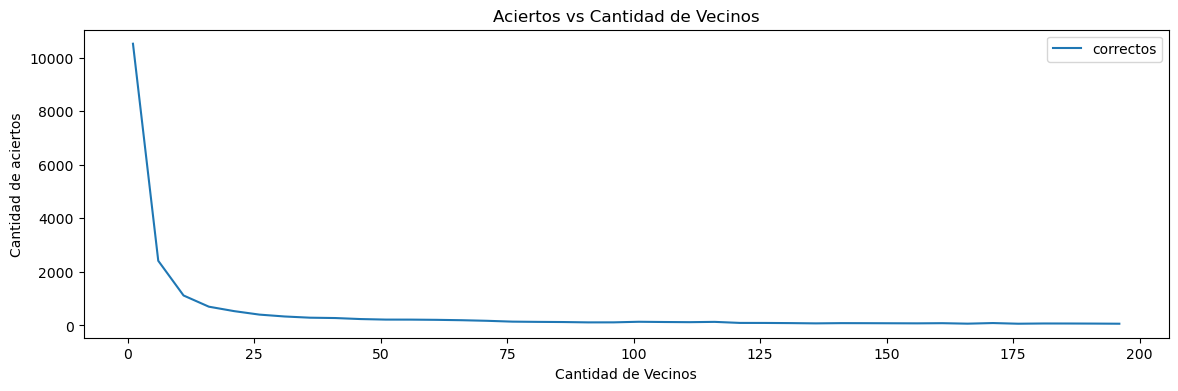

In [134]:
# ploteamos
df_metrics = pd.DataFrame(metrics, columns=['cant_vecinos', 'correctos'])

ax = df_metrics.plot( x='cant_vecinos', 
                      y='correctos',
                      title='Aciertos vs Cantidad de Vecinos'
                     )

ax.set_ylabel("Cantidad de aciertos")
ax.set_xlabel("Cantidad de Vecinos")
plt.show()

En el intervalo 1 a 15 se ve que la performance es mejor, variamos la cantidad de vecinos a ese rango

In [135]:
metrics = [] #cantidad de vecinos y cantidad de aciertos

k_range=range(1, 15,1) # vecinos desde 1 hasta 15 con salto de 1

for n in k_range:

    knn = KNeighborsRegressor(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    metrics.append((n, int((y_test == y_pred).sum())))

Volvemos a plottear

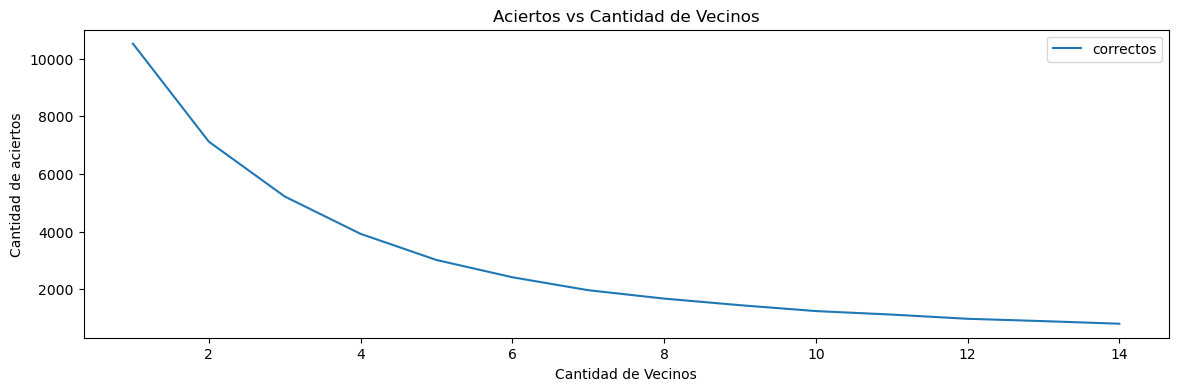

In [136]:
df_metrics = pd.DataFrame(metrics, columns=['cant_vecinos', 'correctos'])

ax = df_metrics.plot( x='cant_vecinos', 
                      y='correctos',
                      title='Aciertos vs Cantidad de Vecinos'
                     )

ax.set_ylabel("Cantidad de aciertos")
ax.set_xlabel("Cantidad de Vecinos")
plt.show()

In [137]:
params_grid = { 'n_neighbors':range(1,15,1), 
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['cityblock',
              'euclidean',
              'manhattan',]
             }
params_grid

{'n_neighbors': range(1, 15),
 'weights': ['distance', 'uniform'],
 'algorithm': ['ball_tree', 'kd_tree', 'brute'],
 'metric': ['cityblock', 'euclidean', 'manhattan']}

In [138]:
cantidad_tuplas = 1
for param in params_grid:
    cantidad_tuplas *= len(params_grid[param])
cantidad_tuplas

252

In [139]:
#Clasificador KNN
knn=KNeighborsClassifier()

#Random Search con 10 Folds 
grid = RandomizedSearchCV(knn, params_grid, cv=10, scoring='neg_root_mean_squared_error', n_iter=20, random_state=2)

grid.fit(X_train, y_train)
grid.cv_results_['mean_test_score']

array([-0.69763492, -0.68330577, -0.68341422, -0.67527291, -0.67590191,
       -0.68738106, -0.67967777, -0.68579852, -0.69975729, -0.71315814,
       -0.65893478, -0.67461238, -0.66187304, -0.66184   , -0.67827676,
       -0.69315706, -0.6842375 , -0.68379192, -0.67461238, -0.66169174])

Mejores parametros

In [140]:
print(grid.best_params_)

{'weights': 'distance', 'n_neighbors': 6, 'metric': 'cityblock', 'algorithm': 'ball_tree'}


Mejor metrica

In [141]:
print(grid.best_score_)

-0.6589347816087031


In [145]:
#Mejor estimador
best_knn=grid.best_estimator_

#Predicción con mejor estimador
y_pred_test=best_knn.predict(X_test)
y_pred_train=best_knn.predict(X_train)

In [147]:
predicciones = best_knn.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )

print(f"El error RMSE de test es: {rmse}")

El error RMSE de test es: 0.6513853769719193


[[2469 1469  245]
 [1092 5847 1395]
 [ 151 1475 2390]]


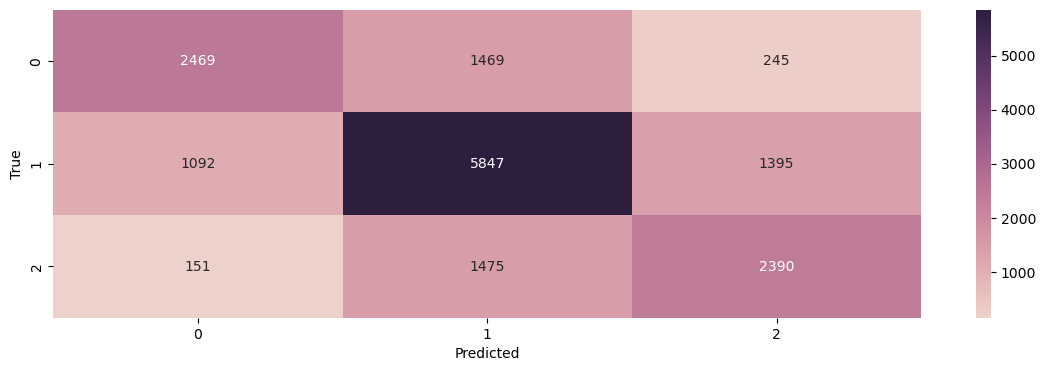

In [148]:
# Matriz
mc = confusion_matrix(y_test, predicciones)
print(mc)

# Heatmap
sns.heatmap(mc, annot=True, fmt='g', cmap=sns.cubehelix_palette(as_cmap=True))

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Podemos observar que ambos arboles de decisión crean reglas que uno puede asumir como correctas, si el barrio es puerto madero, o que los edificios que se ubican en zona norte de la capital tienden a ser de un tipo de precio mas elevado.
El tercer modelo elegido, KNN, no dar estimaciones correctas.

# Conclusiones

Se pudieron observar como los distintos modelos crean reglas que podemos tomar como las correctas tienden a se de un tipo de precio más elevado, como por ejemplo, el Árbol de decisión se puede ver que los precios son más altos
si el inmobiliario esta cerca de un río o si se encuentran dentro de barrios como 'Puerto Madero'. Pero con el 
tercer modelo elegido no pudimos dar estimaciones correctas acerca de como varían los precios.